In [1]:
# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter


/home/vincent/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

# Improved CICIDS2017

In [3]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df

    

In [4]:
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = ['monday.csv', 
                  'tuesday.csv', 
                  'wednesday.csv', 
                  'thursday.csv', 
                  'friday.csv']


def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
    dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']
    improved_df = clean_df(improved_df)
    improved_df.drop(dropping_cols, axis = 1, inplace = True)
    improved_df['Label'].value_counts()    
    return improved_df
improved_df = read_csv()

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


In [5]:
improved_df['Label'].value_counts()

Label
BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                    

In [6]:
improved_df['Attempted Category'].value_counts()

Attempted Category
0    2092837
1       4067
6       2804
5        138
4         75
3         27
2         23
Name: count, dtype: int64

In [7]:
attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]

improved_df.drop(['Attempted Category'], axis = 1, inplace = True)

improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
improved_df['Label'].value_counts()

Label
BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [8]:
#### Sample out Malicious data such that it would become an outlier
print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
print(f'improved_df.shape {improved_df.shape} after Sampling Out')

improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1746169, 83) after Sampling Out


In [9]:
ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

Ratio of Benign to Anomaly is 10.516062230839747 : 1


# Train, validation, and test split

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()

In [11]:
Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
X = improved_df.copy().drop(columns=["Label"], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

train_perc = 0.15

# benign trainin and testing

X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    Y,
                                                    test_size = 1-train_perc, 
                                                    shuffle = True, 
                                                    stratify = Y, 
                                                    random_state = 0)




In [12]:
from sklearn import metrics

def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)

In [13]:
idx = np.where(y_train==1)
idx

(array([     9,     14,     23, ..., 261889, 261909, 261921]),)

In [14]:
# y = np.zeros_like(y_train.values)
# y[:2] = 1
# clf = PReNet( device = 'cuda', verbose=1, epochs=1)
# clf.fit(X=X_train.to_numpy(), y = y)

In [15]:
# pred = clf.predict(X_test.to_numpy())
# get_score(pred, y_test)


In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Example data
# anomaly_scores = clf.decision_function(X_test.to_numpy())




# Model Evaluations

## Unsupervised

In [28]:
def plot_graph(anomaly_scores, y_test):
    # Separate anomaly scores based on the labels
    scores_inliers = anomaly_scores[y_test == 0]  # Assuming '0' is the label for inliers
    scores_outliers = anomaly_scores[y_test == 1]  # Assuming '1' is the label for outliers

    # Create the plots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted for better visualization

    # Plot for inliers and outliers
    ax[0].hist(scores_inliers, bins=100, alpha=0.7, label='Inliers', log=True)
    ax[0].hist(scores_outliers, bins=100, alpha=0.7, label='Outliers', log=True)
    ax[0].set_title('Distribution of Anomaly Scores')
    ax[0].set_xlabel('Anomaly Score')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.95, 1.01])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
    pr_auc = auc(recall, precision)
    ax[2].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.5f)' % pr_auc)
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('Precision-Recall Curve')
    ax[2].legend(loc="lower left")

    # Show the plot
    plt.show()

# Example usage
# anomaly_scores = np.array([...])  # Your anomaly scores array
# y_test = np.array([...])  # Your ground truth labels array
# plot_graph(anomaly_scores, y_test)

def plot_comparison_graph(metrics_dict, supervision_rate_list):
  fig, ax = plt.subplots(4, 1, figsize=(10, 16))  # Create a figure and a set of subplots.

  # Plot ROC curves on the first subplot
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[0].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[0].set_title('ROC Curve Comparison')
  ax[0].set_xlabel('False Positive Rate')
  ax[0].set_ylabel('True Positive Rate')
  ax[0].legend()
  ax[0].grid(True)
  
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[1].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[1].set_title('ROC Curve Comparison')
  ax[1].set_xlabel('False Positive Rate')
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_ylim([0.9,1.02])
  ax[1].legend()
  ax[1].grid(True)  

  # Plot Precision-Recall curves on the second subplot
  for rate, precision in metrics_dict['precision'].items():
      recall = metrics_dict['recall'][rate]
      pr_auc = auc(recall,precision)
      ax[2].plot(recall, precision, label=f'Supervision {rate*100:.0f}%, area {pr_auc:.5f}')
  ax[2].set_title('Precision-Recall Curve Comparison')
  ax[2].set_xlabel('Recall')
  ax[2].set_ylabel('Precision')
  ax[2].legend()
  ax[2].grid(True)
  
  rate_list = [rate for rate in supervision_rate_list]
  accuracy_list = [metrics_dict['accuracy'][rate] for rate in rate_list]  # Corrected access to accuracy
  labels = [f"{rate*100:.0f}, {metrics_dict['accuracy'][rate]:.5f}" for rate in rate_list]  # Convert rates to percentage labels

  # Set the width of the bars to make them narrower
  bar_width = 0.4  # Smaller value results in narrower bars
  bars = ax[3].bar(labels, accuracy_list, color='skyblue', width=bar_width)

  # Adding labels to each bar
  for bar in bars:
      yval = bar.get_height()
      ax[3].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  
  ax[3].set_xlabel('Supervision Rate (%)')
  ax[3].set_ylabel('Accuracy')
  ax[3].set_title('Model Accuracy at Different Supervision Rates')
  ax[3].set_ylim([0, 1.05])  # Assuming accuracy values are normalized [0,1]
  ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)
  
  plt.tight_layout()
  plt.show()    
  
  
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


In [18]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(anomaly_rate_list, model):
  supervision_rate = 0.25
  for anomaly_rate in anomaly_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    print(Y.value_counts())
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
      # y[12:14] = 1
      # y[:2] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    print(Counter(y))
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    pred = clf.predict(X_test.to_numpy())
    get_score(pred, y_test)
    print(y_test.value_counts())
    anomaly_scores = clf.decision_function(X_test.to_numpy())
    # Separate anomaly scores based on the labels
    plot_graph(anomaly_scores, y_test)



anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate = [1.0, 0.5, 0.25, 0.1, 0.05, 0]
model = PReNet
eval_model_unsupervised(anomaly_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (2099971, 83) after Sampling Out
Ratio of Benign to Anomaly is 3.1548124274134355 : 1
Label
0.0    1594540
1.0     505431
Name: count, dtype: int64
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 0.25
Counter({0.0: 296042, 1.0: 18953})
Start Training...
ensemble size: 1


KeyboardInterrupt: 

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 0.136950, time: 265.6s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.5
Start Training...
ensemble size: 1
epoch  1, training loss: 0.174346, time: 262.6s
Start Inference on the training data...
Accuracy: 0.9998
Precision: 0.9883
Recall: 0.9975
F1 Score: 0.9928
[[1355306     252]
 [     54   21229]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.25
Start Training...
ensemble size: 1
epoch  1, training loss: 0.187936, time: 262.8s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.1
Start Training...
ensemble size: 1
epoch  1, training loss: 0.172567, time: 261.8s
Start Inference on the training data...
Accuracy: 0.9996
Precision: 0.9751
Recall: 0.9970
F1 Score: 0.9860
[[1355298     534]
 [     62   20947]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.176534, time: 267.2s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
UNSUPERVISED, Sampling Rate = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.087790, time: 267.0s
Start Inference on the training data...
Accuracy: 0.9882
Precision: 0.2499
Recall: 0.9833
F1 Score: 0.3985
[[1355269   16113]
 [     91    5368]]


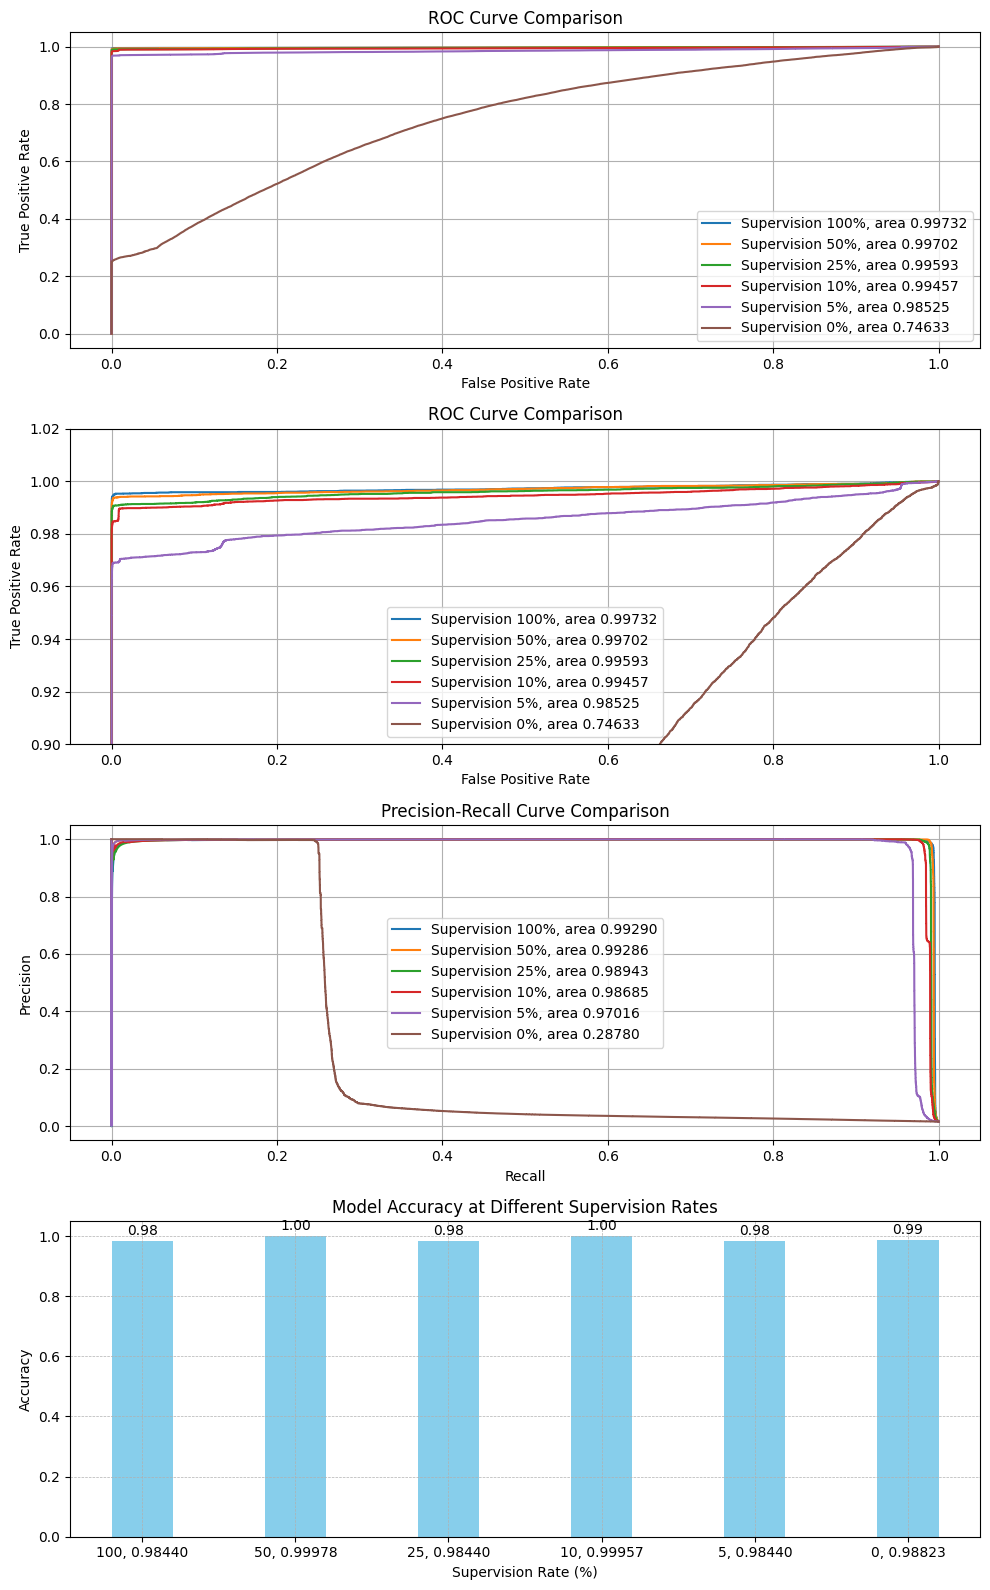

In [ ]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 0.1
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # I DIDN"T ADD THIS BEFOREEE SO NEED TO RERUNNN
    dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']
    improved_df.drop(dropping_cols, axis = 1, inplace = True)         
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    
    # Store metrics
    metrics_dict['fpr'][supervision_rate] = fpr
    metrics_dict['tpr'][supervision_rate] = tpr
    metrics_dict['precision'][supervision_rate] = precision
    metrics_dict['recall'][supervision_rate] = recall
    metrics_dict['accuracy'][supervision_rate] = accuracy    
    
    # Separate anomaly scores based on the labels
    # plot_graph(anomaly_scores, y_test[:1000])
  fig, ax = plt.subplots(4, 1, figsize=(10, 16))  # Create a figure and a set of subplots.

  # Plot ROC curves on the first subplot
  plot_comparison_graph(metrics_dict)



anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate_list = [1.0, 0.5, 0.25, 0.1, 0.05, 0.0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


0.17647031081142991


In [21]:
X_train.shape

(261925, 82)

### 0.15 data for training in 0.1 supervision vs 0.85 for training in 0.05 or 0

In [31]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 0.05
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15 if supervision_rate == 0.1 else 0.3

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    
    # Store metrics
    metrics_dict['fpr'][supervision_rate] = fpr
    metrics_dict['tpr'][supervision_rate] = tpr
    metrics_dict['precision'][supervision_rate] = precision
    metrics_dict['recall'][supervision_rate] = recall
    metrics_dict['accuracy'][supervision_rate] = accuracy    
    
    # Separate anomaly scores based on the labels
  # plot_graph(anomaly_scores, y_test[:1000])
  plot_comparison_graph(metrics_dict, supervision_rate_list)

anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate_list = [0.1, 0.05, 0.01, 0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.1
Start Training...
ensemble size: 1
epoch  1, training loss: 0.195794, time: 264.1s
Start Inference on the training data...
Accuracy: 0.9993
Precision: 0.9587
Recall: 0.9951
F1 Score: 0.9766
[[1355259     887]
 [    101   20594]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...


## Scenario Division

<Axes: >

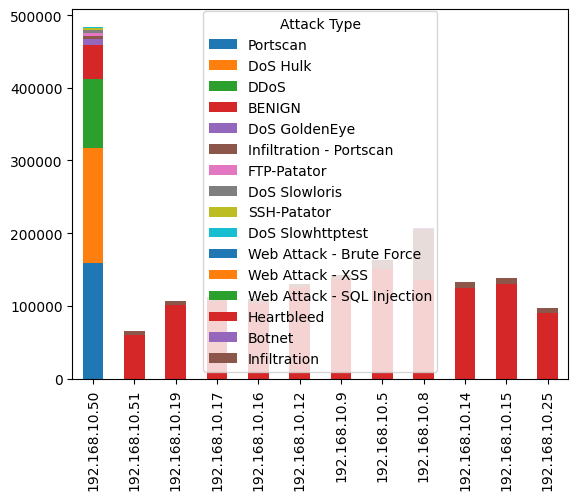

In [14]:
victim_IP = ["192.168.10.50",
             "192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
             "192.168.10.8", "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]
all_counts = pd.DataFrame()
for curr_ip in victim_IP:
    curr_ip_df = improved_df.loc[(improved_df["Src IP"] == curr_ip) | (improved_df["Dst IP"] == curr_ip)]
    counts = curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    all_counts = pd.concat([all_counts, counts], axis=1)
    
all_counts = all_counts.T
all_counts.plot(kind='bar', stacked=True)
plt.xlabel = "Victim IP"
plt.ylabel = "Count"
plt.legend(title="Attack Type")
plt.show()


Obtain new_atk_df from 192.168.10.50

In [15]:
def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def process_dataset(curr_df, anomaly_rate):

    improved_df = curr_df.copy()

    # Clean the labels
    attempted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    if attempted_labels:
        improved_df.drop(['Attempted Category'], axis=1, inplace=True)
        improved_df.replace(attempted_labels, 'BENIGN', inplace=True)

    # Filter and sample the DataFrame
    
    improved_df = sample_df(improved_df, anomaly_rate)
    # Dataset preparation

    Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp', 'Dvc Label']    
    scaler = StandardScaler()
    scaler.fit(X.drop(columns=dropping_cols, axis=1, inplace=False))

    train_perc = 0.15

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        Y, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=Y, 
                                                        random_state=42)
        
    return X_train, X_test, y_train, y_test, scaler
def set_supervised_label(supervision_rate, anomaly_rate, y, idx):
        if supervision_rate == 0:
            print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
            y[idx[:2]] = 1
        else:
            print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
            
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
            
def perform_inference(X_test, y_test, dropping_cols, scaler, clf, curr_ip=None):
    if curr_ip:
        curr_X_test = X_test.loc[X_test["Dvc Label"] == curr_ip].copy()
        curr_y_test = y_test.loc[X_test["Dvc Label"] == curr_ip].copy()
    else:
        curr_X_test = X_test.copy()
        curr_y_test = y_test.copy()
    # curr_X_test.drop(dropping_cols, axis = 1, inplace = True)     
    curr_X_test_scaled = scaler.transform(curr_X_test)
    # Evaluate the model
    anomaly_scores = clf.decision_function(X=curr_X_test_scaled)
    fpr, tpr, _ = roc_curve(curr_y_test, anomaly_scores)
    # Get Labels for Local Model
    precision, recall, thresholds = precision_recall_curve(curr_y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    # opt_threshold = 2.594822645187378
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    roc_auc = auc(fpr, tpr)    
    return roc_auc, curr_X_test_scaled, pred, opt_threshold




    



def plot_graph_scenario(metrics_dict, supervision_rate_list):
    fig, axes = plt.subplots(2,1,figsize=(14, 8))  # Create a figure and a set of subplots.
    ax_n = 0
    for metric_type in metrics_dict:
        curr_ax = axes[ax_n]
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_supervision_rates = len(supervision_rate_list)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_supervision_rates))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(supervision_rate_list):
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(supervision_rate_list):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Supervision Rate: {sr}')

        curr_ax.set_title('ROC AUC Comparison by IP and Supervision Rate')
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_supervision_rates - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)

    plt.tight_layout()
    plt.show()

In [16]:
df = read_csv()


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


### Scenario 1 - One Global Model for all clusters

In [11]:
# Read the csv and clean it
def eval_model_unsupervised(improved_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    X_train, X_test, y_train, y_test, scaler = process_dataset(improved_df, anomaly_rate)

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)

        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
            
        dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                        'Dst Port', 'Timestamp', 'Dvc Label']
        X_train.drop(dropping_cols, axis = 1, inplace = True)     
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
        
        # Train the model
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=X_train_scaled.to_numpy(), y=y)        
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate

            roc_auc = perform_inference(X_test, y_test, curr_ip, dropping_cols, scaler, clf)
            # Store metrics
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 

    return metrics_dict


In [ ]:


victim_IP = ["192.168.10.50",
             "192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
             "192.168.10.8", "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]


model = PReNet
model.random_state = 42
improved_df = df.copy()
metrics_dict = eval_model_unsupervised(improved_df, supervision_rate_list, model, victim_IP)
plot_graph_scenario(metrics_dict, supervision_rate_list)
print(metrics_dict)

### Scenario 2: One Global Model For Each Cluster

46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 1.097874, time: 0.4s
Start Inference on the training data...
46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.872495, time: 0.4s
Start Inference on the training data...
46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
UNSUPERVISED, Sampling Rate = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.930409, time: 0.4s
Start Inference on the training data...


1264641 72550 0.05736805939393077
Ratio of Benign to Anomaly is 20.000015814777328 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.324872, time: 184.6s
Start Inference on the training data...
1264641 72550 0.05736805939393077
Ratio of Benign to Anomaly is 20.000015814777328 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.291438, time: 183.8s
Start Inference on the training data...
1264641 72550 0.05736805939393077
Ratio of Benign to Anomaly is 20.000015814777328 : 1
UNSUPERVISED, Sampling Rate = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.113476, time: 184.5s
Start Inference on the training data...


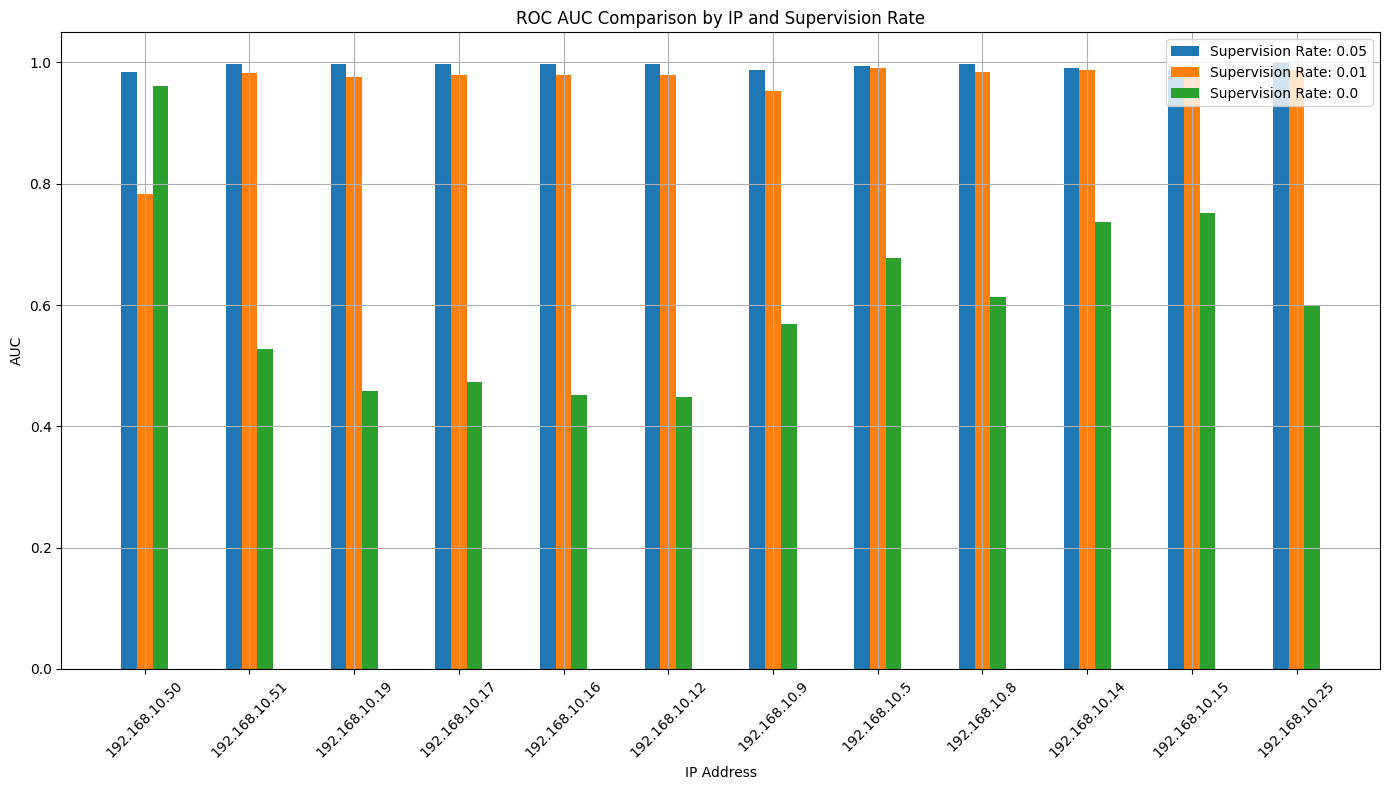

{'roc_auc': {'192.168.10.50': {0.05: 0.9842946904146498, 0.01: 0.7827804008000877, 0.0: 0.9609623931875906}, '192.168.10.51': {0.05: 0.9982204584051813, 0.01: 0.9829349690294258, 0.0: 0.5269545575725361}, '192.168.10.19': {0.05: 0.9966727374082696, 0.01: 0.9761589490978339, 0.0: 0.45820438751985715}, '192.168.10.17': {0.05: 0.9974991051812024, 0.01: 0.9799355268717499, 0.0: 0.4725353226900603}, '192.168.10.16': {0.05: 0.9978804901103675, 0.01: 0.9793739028626549, 0.0: 0.45134018249030583}, '192.168.10.12': {0.05: 0.9974981108758989, 0.01: 0.9799612817540112, 0.0: 0.44882307080842954}, '192.168.10.9': {0.05: 0.9866868437223385, 0.01: 0.9521249004922377, 0.0: 0.5682572101755888}, '192.168.10.5': {0.05: 0.994206919435459, 0.01: 0.9915458368404686, 0.0: 0.6771901270455839}, '192.168.10.8': {0.05: 0.996974254139416, 0.01: 0.9833932718258911, 0.0: 0.6137207157202902}, '192.168.10.14': {0.05: 0.9911276508215687, 0.01: 0.9874900826116015, 0.0: 0.7369418729822313}, '192.168.10.15': {0.05: 0.985

In [16]:
def eval_model_unsupervised(supervision_rate_list, model, cluster_dict):
    anomaly_rate = 0.05
    ip_list = [ip for cluster_ip in cluster_dict.values() for ip in cluster_ip]
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in ip_list}
    }
    for cluster in cluster_dict.keys(): #Train Based on Cluster Data
        victim_IP = cluster_dict[cluster]
        for supervision_rate in supervision_rate_list:
            improved_df = df.copy()

            # Clean the labels
            attempted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
            improved_df.drop(['Attempted Category'], axis=1, inplace=True)
            improved_df.replace(attempted_labels, 'BENIGN', inplace=True)

            # Filter and sample the DataFrame
            improved_df = improved_df.loc[(improved_df["Src IP"].isin(victim_IP)) | (improved_df["Dst IP"].isin(victim_IP))].copy()
            improved_df = sample_df(improved_df, anomaly_rate)
            # Dataset preparation

            Y = improved_df['Label'].map({"BENIGN": 0}).fillna(1)
            X = improved_df.copy().drop(columns=["Label"], axis=1)


            train_perc = 0.15
            dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                            'Dst Port', 'Timestamp']            
            scaler = StandardScaler()
            X_temp = X.drop(columns = dropping_cols, axis = 1, inplace = False)
            _ = scaler.fit_transform(X_temp)
            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                Y, 
                                                                test_size=1 - train_perc, 
                                                                shuffle=True, 
                                                                stratify=Y, 
                                                                random_state=42)
            # Prepare labels for semi-supervised learning
            idx = np.where(y_train == 1)[0]
            y = np.zeros_like(y_train.values)
            if supervision_rate == 0:
                print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
                y[idx[:2]] = 1
            else:
                print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
                np.random.seed(42)
                idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False, )
                y[idx] = 1
                
                

            X_train.drop(dropping_cols, axis = 1, inplace = True)     
                
            
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
            
            # Train the model
            clf = model(device='cuda', verbose=1, epochs=1)
            clf.fit(X=X_train_scaled.to_numpy(), y=y)        
            
            for curr_ip in victim_IP:
                # Create a fresh copy of the DataFrame for each IP and supervision rate
                curr_X_test = X_test.loc[(X_test["Src IP"] == curr_ip) | (X_test["Dst IP"] == curr_ip)].copy()
                curr_y_test = y_test.loc[(X_test["Src IP"] == curr_ip) | (X_test["Dst IP"] == curr_ip)].copy()
                curr_X_test.drop(dropping_cols, axis = 1, inplace = True)     
                curr_X_test_scaled = scaler.transform(curr_X_test)
                
                
                # Evaluate the model
                anomaly_scores = clf.decision_function(curr_X_test_scaled)
                fpr, tpr, _ = roc_curve(curr_y_test, anomaly_scores)
                roc_auc = auc(fpr, tpr)

                # Store metrics
                metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 
        
    return metrics_dict


cluster_dict = {"cluster_1" : ["192.168.10.50"],
           "cluster_2" : ["192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
             "192.168.10.8", "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]}
             
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]


model = PReNet
model.random_state=42
metrics_dict = eval_model_unsupervised(supervision_rate_list, model, cluster_dict)
plot_graph_scenario(metrics_dict, supervision_rate_list)
print(metrics_dict)

### Scenario 3: One Global Model For Each Device

46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 1.097874, time: 0.4s
Start Inference on the training data...
46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.872495, time: 0.4s
Start Inference on the training data...
46472 437582 9.416035462213806
Ratio of Benign to Anomaly is 19.99655765920826 : 1
UNSUPERVISED, Sampling Rate = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.930409, time: 0.4s
Start Inference on the training data...
59425 5698 0.09588557004627682
Ratio of Benign to Anomaly is 20.00168293503871 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.762481, time: 0.6s
Start Inference

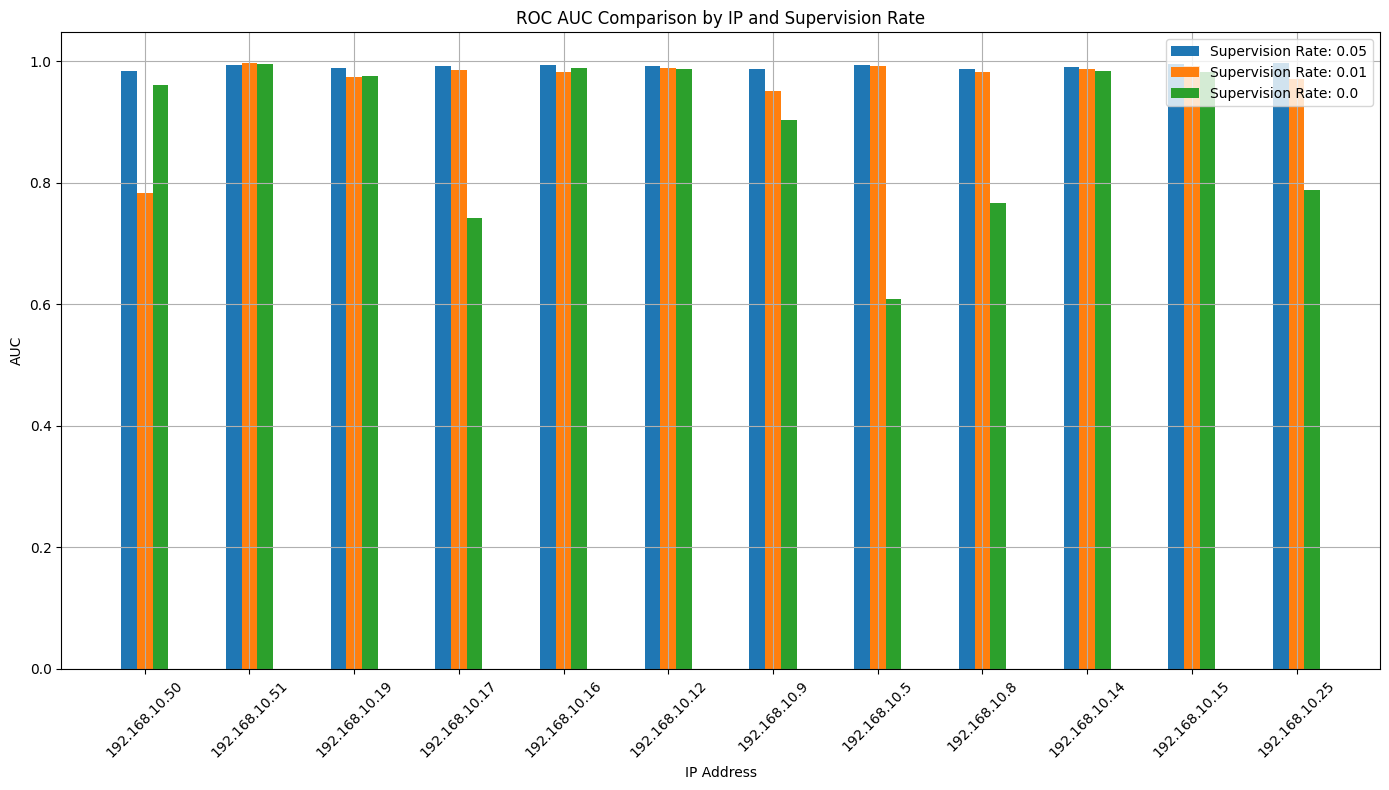

{'roc_auc': {'192.168.10.50': {0.05: 0.9842946904146498, 0.01: 0.7827804008000877, 0.0: 0.9609623931875906}, '192.168.10.51': {0.05: 0.9942865218577606, 0.01: 0.9971529713947005, 0.0: 0.9962037018161746}, '192.168.10.19': {0.05: 0.9889306264787457, 0.01: 0.9736808697811752, 0.0: 0.976651117304367}, '192.168.10.17': {0.05: 0.9924912065953626, 0.01: 0.9856772164186802, 0.0: 0.7428254148937511}, '192.168.10.16': {0.05: 0.993627488755036, 0.01: 0.9829845444442553, 0.0: 0.9886398164826778}, '192.168.10.12': {0.05: 0.9932515845149188, 0.01: 0.9898591669304868, 0.0: 0.9879079272838325}, '192.168.10.9': {0.05: 0.9880337975419969, 0.01: 0.9519591847865609, 0.0: 0.9039579625614005}, '192.168.10.5': {0.05: 0.9938412574430575, 0.01: 0.9926673056564419, 0.0: 0.6089286965444313}, '192.168.10.8': {0.05: 0.9881050567292262, 0.01: 0.9832459612277831, 0.0: 0.7673336379806699}, '192.168.10.14': {0.05: 0.9904803898529634, 0.01: 0.9869809179083547, 0.0: 0.9839501702619741}, '192.168.10.15': {0.05: 0.995330

In [17]:
# Read the csv and clean it
def eval_model_unsupervised(supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    for curr_ip in victim_IP:
        for supervision_rate in supervision_rate_list:
            # Create a fresh copy of the DataFrame for each IP and supervision rate
            improved_df = df.copy()

            # Clean the labels
            attempted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
            improved_df.drop(['Attempted Category'], axis=1, inplace=True)
            improved_df.replace(attempted_labels, 'BENIGN', inplace=True)

            # Filter and sample the DataFrame
            curr_ip_df = improved_df.loc[(improved_df["Src IP"] == curr_ip) | (improved_df["Dst IP"] == curr_ip)]
            curr_ip_df = sample_df(curr_ip_df, anomaly_rate)

            # Dataset preparation
            dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                            'Dst Port', 'Timestamp']
            curr_ip_df.drop(dropping_cols, axis = 1, inplace = True)                 
            scaler = StandardScaler()
            Y = curr_ip_df['Label'].map({"BENIGN": 0}).fillna(1)
            X = curr_ip_df.copy().drop(columns=["Label"], axis=1)
            X_scaled = scaler.fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

            train_perc = 0.15

            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                                Y, 
                                                                test_size=1 - train_perc, 
                                                                shuffle=True, 
                                                                stratify=Y, 
                                                                random_state=42)

            # Prepare labels for semi-supervised learning
            idx = np.where(y_train == 1)[0]
            y = np.zeros_like(y_train.values)
            if supervision_rate == 0:
                print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
                y[idx[:2]] = 1
            else:
                print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
                np.random.seed(42)
                idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
                y[idx] = 1


            # Train the model
            clf = model(device='cuda', verbose=1, epochs=1)
            clf.fit(X=X_train.to_numpy(), y=y)

            # Evaluate the model
            anomaly_scores = clf.decision_function(X_test.to_numpy())
            fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
            roc_auc = auc(fpr, tpr)

            # Store metrics
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 

    return metrics_dict


victim_IP = ["192.168.10.50",
             "192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
             "192.168.10.8", "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]

model = PReNet
model.random_state=42

metrics_dict = eval_model_unsupervised(supervision_rate_list, model, victim_IP)
plot_graph_scenario(metrics_dict, supervision_rate_list)
print(metrics_dict)

# Device Creation

In [17]:
victim_IP = ["192.168.10.50",
             "192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
            #  "192.168.10.8", 
             "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]
victim_df = improved_df[improved_df["Src IP"].isin(victim_IP) | improved_df["Dst IP"].isin(victim_IP)].copy()
victim_df["Dvc Label"] = np.where(victim_df["Src IP"].isin(victim_IP), victim_df["Src IP"], victim_df["Dst IP"])
victim_df["Dvc Label"].value_counts()

Dvc Label
192.168.10.50    473547
192.168.10.5     163147
192.168.10.9     143199
192.168.10.15    138868
192.168.10.14    133340
192.168.10.12    130046
192.168.10.17    111538
192.168.10.16    108755
192.168.10.19    106119
192.168.10.25     96260
192.168.10.51     65120
Name: count, dtype: int64

### Clustering and T-SNE Projection

In [11]:
y = victim_df["Dvc Label"]
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label', "Label"]
X = victim_df.drop(dropping_cols, axis=1, inplace=False)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<Figure size 2000x1600 with 0 Axes>

The palette list has more values (12) than needed (11), which may not be intended.


[Text(0.5, 1.0, 'Device Label Projection')]

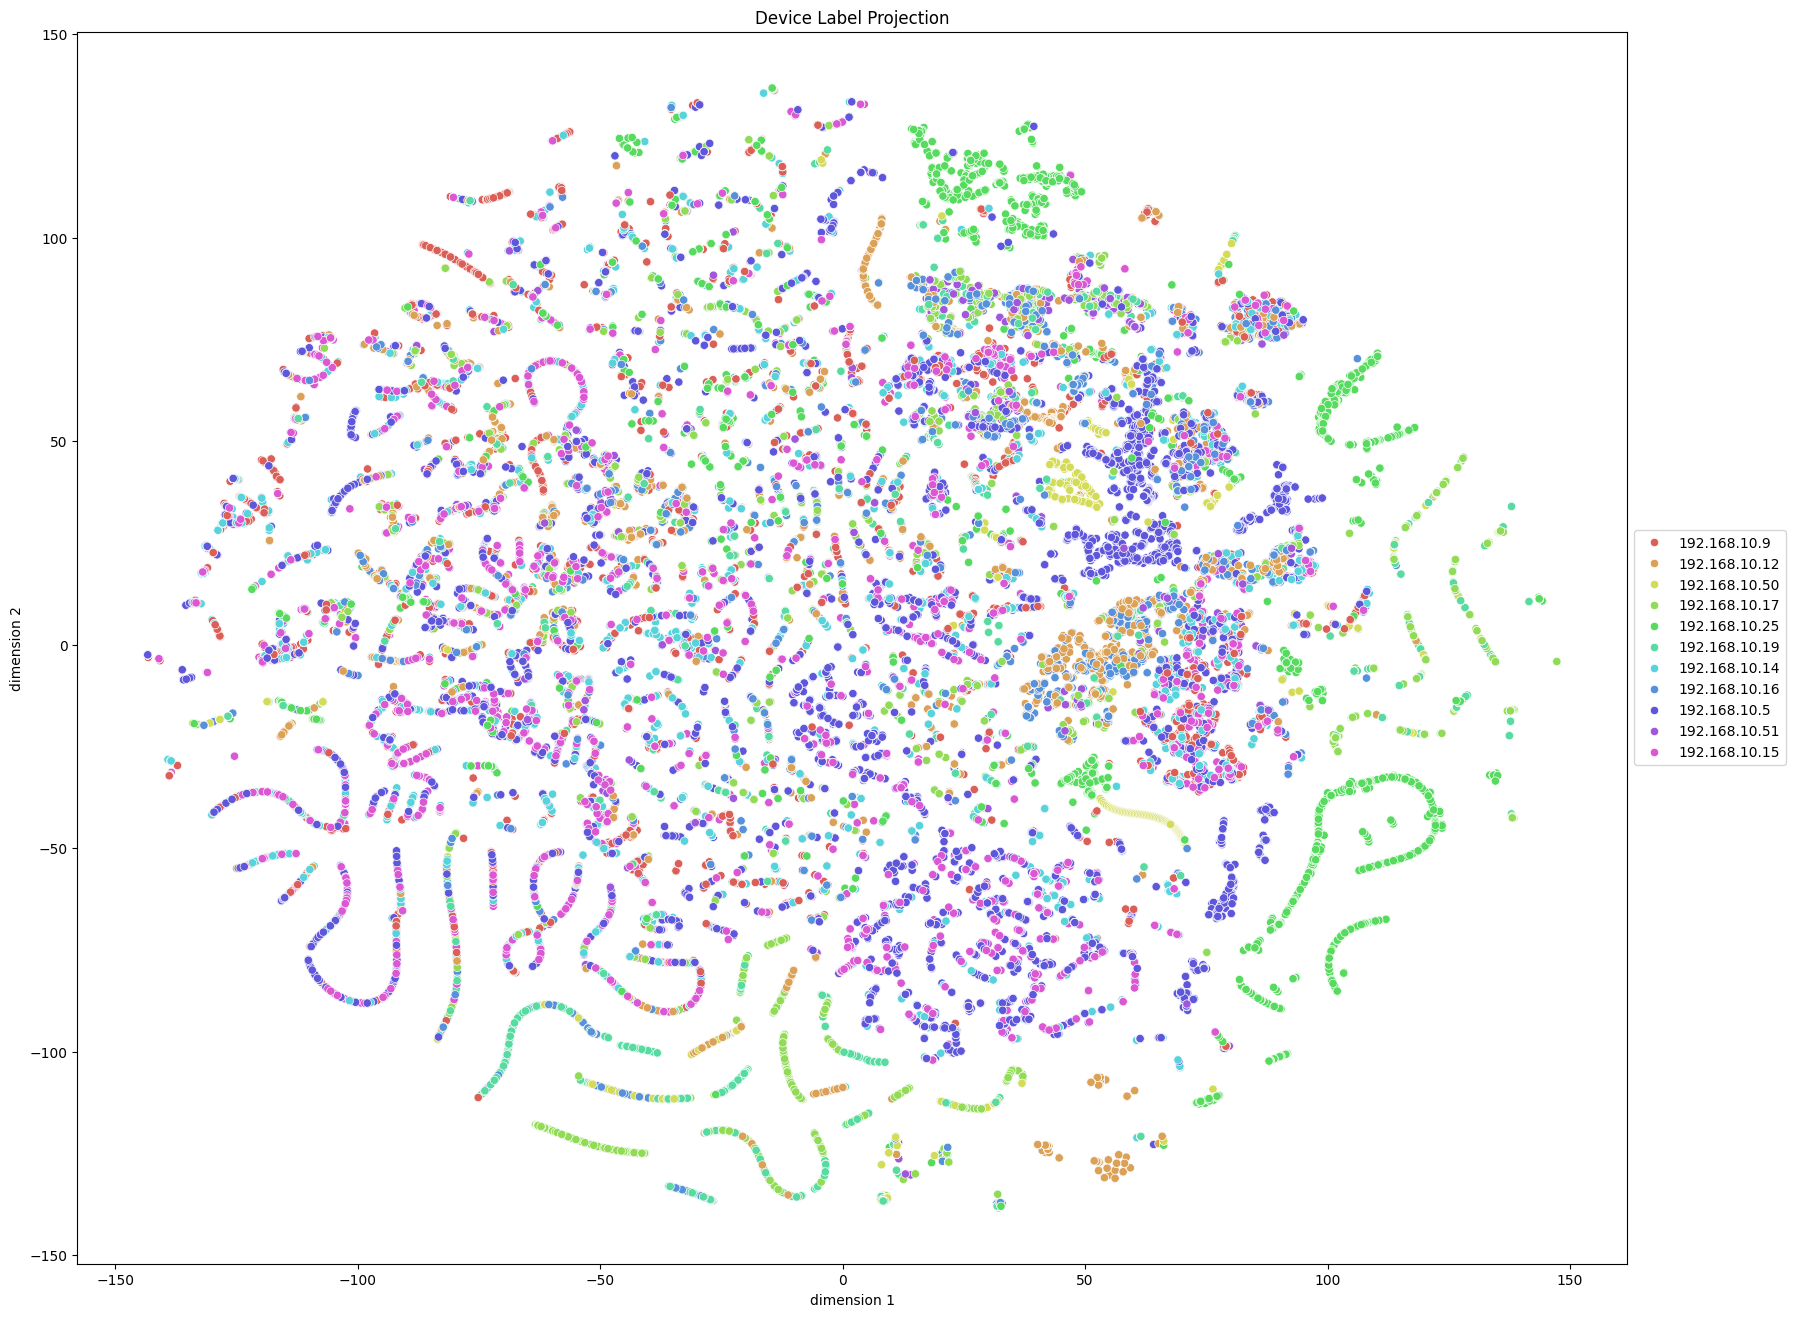

In [11]:
tsne = TSNE(n_components = 2, n_jobs = -1, verbose = 0, random_state=42)
z = tsne.fit_transform(X_scaled[:50000])

tsne_df = pd.DataFrame()
tsne_df["Dvc Label"] = y[:50000]
tsne_df["dimension 1"] = z[:,0]
tsne_df["dimension 2"] = z[:,1]
plt.figure(figsize=(20,16))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2',
                hue = tsne_df["Dvc Label"],
                palette = sns.color_palette('hls', 12),
                data = tsne_df).set(title = 'Device Label Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

In [12]:
y = victim_df["Dvc Label"]
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label', "Label"]
X = victim_df.drop(dropping_cols, axis=1, inplace=False)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 2, random_state=42)
z = pca.fit_transform(X_scaled[:])



<Figure size 1000x600 with 0 Axes>

The palette list has more values (12) than needed (11), which may not be intended.


[Text(0.5, 1.0, 'Device Label Projection')]

(-5.0, 20.0)

(-40.0, 30.0)

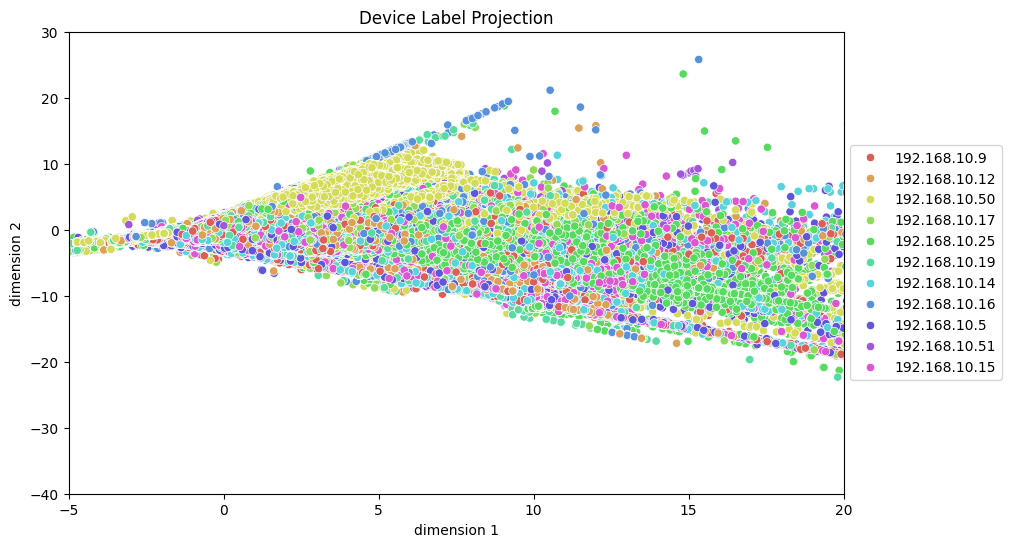

In [13]:
pca_df = pd.DataFrame()
pca_df["Dvc Label"] = y[:]
pca_df["dimension 1"] = z[:,0]
pca_df["dimension 2"] = z[:,1]
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2',
                hue = pca_df["Dvc Label"],
                palette = sns.color_palette('hls', 12),
                data = pca_df).set(title = 'Device Label Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.xlim(-5,20)
plt.ylim(-40,30)
plt.show()

### Device Data Partitioning using Cluster Algorithm

In [18]:
ip = "192.168.10.50"
device_df = victim_df.loc[victim_df["Dvc Label"] == ip]
# device_df = victim_df.loc[(victim_df["Src IP"] == ip) | (victim_df["Dst IP"] == ip)].copy()

In [19]:
# victim_IP = [
#              "192.168.10.50",
#              "192.168.10.51", "192.168.10.19",
#              "192.168.10.16", "192.168.10.12",
#              "192.168.10.9", "192.168.10.5",
#              "192.168.10.8", "192.168.10.14",
#              "192.168.10.15", "192.168.10.25"]
# ip = "192.168.10.17"
# test_df = victim_df.loc[((victim_df['Src IP'] == ip) | (victim_df['Dst IP'] == ip)) & 
#                         (victim_df['Src IP'].isin(victim_IP) | (victim_df['Dst IP'].isin(victim_IP)))]
# test_df["Dvc Label"].value_counts()

<Figure size 1000x600 with 0 Axes>

[Text(0.5, 1.0, 'Device 1 Label Projection')]

(-10.0, 50.0)

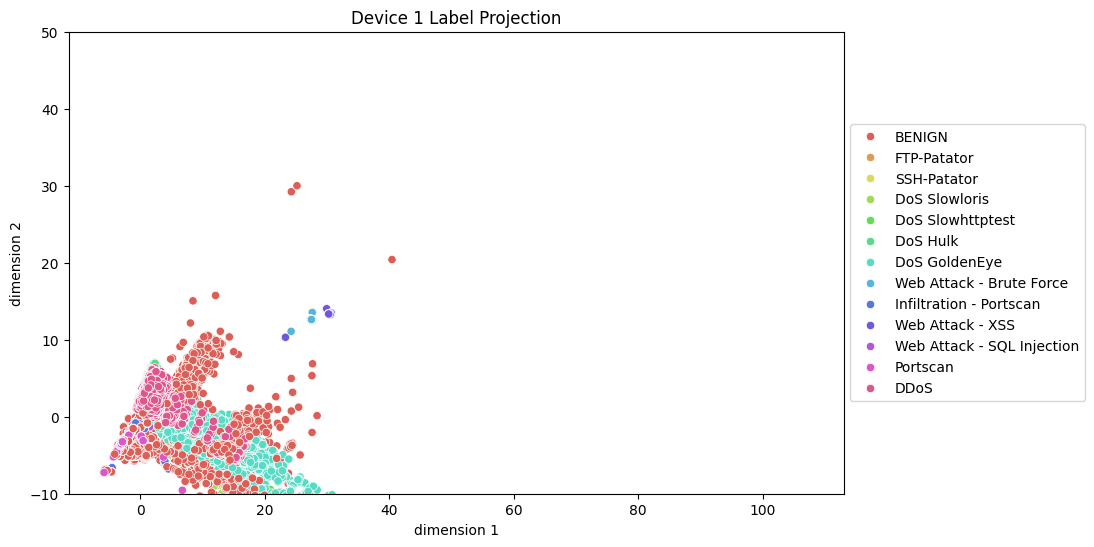

In [20]:
y = device_df["Label"]
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label', "Label"]
X = device_df.drop(dropping_cols, axis=1, inplace=False)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components = 2, random_state=42)
z = pca.fit_transform(X_scaled[:])

pca_df = pd.DataFrame()
pca_df["Dvc Label"] = y[:]
pca_df["dimension 1"] = z[:,0]
pca_df["dimension 2"] = z[:,1]
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'dimension 1', y = 'dimension 2',
                hue= y, 
                 palette = sns.color_palette('hls', 13),
                data = pca_df).set(title = 'Device 1 Label Projection') 
plt.ylim(-10,50)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

In [15]:
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
def device_data_clustering(X, model, n_components=None, plot = False, plot_title='Cluster Projection', n_clusters=None):

    if n_components is not None:
        pca = PCA(n_components=n_components, random_state=42)
        X_reduced = pca.fit_transform(X)
    else:
        X_reduced = X

    # Prepare the model if not instantiated (e.g., for KMeans or Birch)
    if model is None and n_clusters is not None:
        model = KMeans(n_clusters=n_clusters, random_state=42)  # Default to KMeans if unspecified

    # Fit the model
    model.fit(X)

    # Predict clusters
    preds = model.predict(X_reduced)
    if plot:
        # Create a DataFrame for plotting
        pca_df = pd.DataFrame(X_reduced, columns=['dimension 1', 'dimension 2'])

        # Plotting
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='dimension 1', y='dimension 2',
                        hue=preds, 
                        palette=sns.color_palette('hls', max(5, np.unique(preds).size)),  # Ensure enough colors
                        data=pca_df).set(title=plot_title)
        plt.legend(title='Cluster')
        plt.ylim(-10, 50)  # Set consistent y-limits for comparison
        plt.show()
    return preds
X_scaled = StandardScaler().fit_transform(X)  # Assuming X is defined
# device_data_clustering(X_scaled, KMeans(n_clusters=2, random_state=42), n_components=2)
# device_data_clustering(X_scaled, Birch(n_clusters=2, threshold=0.5), n_components=2)
# device_data_clustering(X_scaled, GaussianMixture(n_components=3, random_state=42), n_components=2, plot=True)


### Sub Device Creation

In [21]:
victim_IP = ["192.168.10.50",
             "192.168.10.51",
             "192.168.10.19", "192.168.10.17",
             "192.168.10.16", "192.168.10.12",
             "192.168.10.9", "192.168.10.5",
            #  "192.168.10.8", 
             "192.168.10.14",
             "192.168.10.15", "192.168.10.25"]
victim_df = improved_df[improved_df["Src IP"].isin(victim_IP) | improved_df["Dst IP"].isin(victim_IP)].copy()
victim_df["Dvc Label"] = np.where(victim_df["Src IP"].isin(victim_IP), victim_df["Src IP"], victim_df["Dst IP"])
victim_df["Dvc Label"].value_counts()
# y = victim_df["Dvc Label"]
# dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
#                 'Dst Port', 'Timestamp', 'Dvc Label', "Label"]
# X = victim_df.drop(dropping_cols, axis=1, inplace=False)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)




Dvc Label
192.168.10.50    473547
192.168.10.5     163147
192.168.10.9     143199
192.168.10.15    138868
192.168.10.14    133340
192.168.10.12    130046
192.168.10.17    111538
192.168.10.16    108755
192.168.10.19    106119
192.168.10.25     96260
192.168.10.51     65120
Name: count, dtype: int64

GM Clustering

In [22]:
# ip = "192.168.10.50"
# device_df = victim_df.loc[victim_df["Dvc Label"] == ip].copy()
# # device_df = victim_df.loc[(victim_df['Src IP'] == ip) | (victim_df['Dst IP'] == ip)]

# y = device_df["Label"]
# dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
#                 'Dst Port', 'Timestamp', 'Dvc Label', "Label"]
# X = device_df.drop(dropping_cols, axis=1, inplace=False)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# preds = device_data_clustering(X_scaled, GaussianMixture(n_components=3, random_state=42), n_components=3)

# if ip == "192.168.10.50":
#   all_counts = partition_device("cluster", victim_df, ip,preds)
# all_counts.plot(kind='bar', stacked=True)
# plt.xlabel = "Victim IP"
# plt.ylabel = "Count"
# plt.legend(title="Attack Type")
# plt.show()  

In [23]:
def generate_random_proportions(num_partition):
    while True:
        # Generate three random numbers
        proportions = np.random.random(num_partition)
        # Normalize these numbers so they sum to 1
        proportions /= proportions.sum()
        
        # Adjust proportions to sum to 1 but each being between 0.2 and 0.4
        if np.all(proportions >= 1/num_partition-0.25/num_partition) and np.all(proportions <= 1/num_partition + 0.25/num_partition):
            return proportions
partition_sizes = generate_random_proportions(5)  
partition_sizes


array([0.21039139, 0.23257047, 0.15194111, 0.20977614, 0.19532089])

In [24]:
# Assume df is your DataFrame
np.random.seed(42)  # For reproducibility
          
def partition_device(method, victim_df, curr_ip, preds=None, partition_size = 50000):
  device_df = victim_df.loc[victim_df["Dvc Label"] == curr_ip].copy()
  new_victim_df = victim_df.copy()
  if method == "cluster":
    clusters = np.unique(preds)
    all_counts = pd.DataFrame()

    for cluster in clusters:
      idx = np.where(preds == cluster)
      cluster_df = device_df.iloc[idx]
      counts = cluster_df["Label"].value_counts()
      counts.name = cluster
      all_counts = pd.concat([all_counts, counts], axis=1)
      
    all_counts = all_counts.T
    preds_df = pd.DataFrame(preds, index = device_df.index, columns = ["Cluster"])
    preds_df["Cluster"] = preds_df["Cluster"].apply(lambda x: chr(97+x))
    new_victim_df.loc[preds_df.index, "Dvc Label"] = ip+ preds_df["Cluster"]
    
    return new_victim_df
  if method == "equal":
    #Decide how many partition to make
    num_partition = int(np.ceil(device_df[device_df["Label"] == "BENIGN"].shape[0] / partition_size))
    proportions = generate_random_proportions(num_partition)
    proportions_idx = np.cumsum([0]+list(proportions))[:]    
    data_size = device_df.shape[0]
    idx_arr = np.array(device_df.index)
    np.random.shuffle(idx_arr)
    print(proportions_idx, curr_ip)
    for i in range(1, num_partition+1):
        start_idx = int(proportions_idx[i - 1]*data_size)
        end_idx = int(proportions_idx[i]*data_size)
        new_victim_df.loc[idx_arr[start_idx:end_idx], 'Dvc Label'] = curr_ip + chr(97 + i - 1)
    return new_victim_df



In [25]:
new_victim_df = victim_df.copy()
for ip in victim_IP:
  if ip == "192.168.10.50":
    new_victim_df = partition_device("equal", new_victim_df, ip, partition_size=17000)
    # new_victim_df = partition_device("cluster", new_victim_df, ip,preds)
  else:
    new_victim_df = partition_device("equal", new_victim_df, ip)

#Filter Out the leftover partition
label_counts = new_victim_df["Dvc Label"].value_counts()
filtered_labels = label_counts[label_counts > 2].keys()

new_victim_df = new_victim_df[new_victim_df["Dvc Label"].isin(filtered_labels)]
new_victim_df["Dvc Label"].value_counts()

new_victim_df.to_csv("new_victim_df.csv")


[0.         0.34848152 0.70311325 1.        ] 192.168.10.50
[0.         0.39060324 1.        ] 192.168.10.51
[0.         0.28318737 0.67104047 1.        ] 192.168.10.19
[0.         0.32747668 0.70959865 1.        ] 192.168.10.17
[0.         0.38061203 0.72534855 1.        ] 192.168.10.16
[0.         0.37642907 0.68655387 1.        ] 192.168.10.12
[0.         0.26019874 0.64762399 1.        ] 192.168.10.9
[0.         0.20753906 0.42600003 0.69757    1.        ] 192.168.10.5
[0.         0.38256854 0.65997809 1.        ] 192.168.10.14
[0.         0.35367357 0.63073979 1.        ] 192.168.10.15
[0.         0.58047267 1.        ] 192.168.10.25


Dvc Label
192.168.10.50b    167935
192.168.10.50a    165022
192.168.10.50c    140590
192.168.10.25a     55876
192.168.10.9b      55479
192.168.10.15c     51279
192.168.10.14a     51011
192.168.10.9c      50460
192.168.10.5d      49340
192.168.10.15a     49113
192.168.10.12a     48953
192.168.10.14c     45339
192.168.10.5c      44306
192.168.10.17b     42621
192.168.10.16a     41393
192.168.10.19b     41159
192.168.10.12c     40763
192.168.10.25b     40384
192.168.10.12b     40330
192.168.10.51b     39684
192.168.10.15b     38476
192.168.10.16b     37492
192.168.10.9a      37260
192.168.10.14b     36990
192.168.10.17a     36526
192.168.10.5b      35641
192.168.10.19c     34908
192.168.10.5a      33859
192.168.10.17c     32391
192.168.10.19a     30051
192.168.10.16c     29869
192.168.10.51a     25436
Name: count, dtype: int64

<Axes: title={'center': 'All Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'Sampled Counts'}>

Text(0.5, 0, 'Victim IP')

Text(0, 0.5, 'Count')

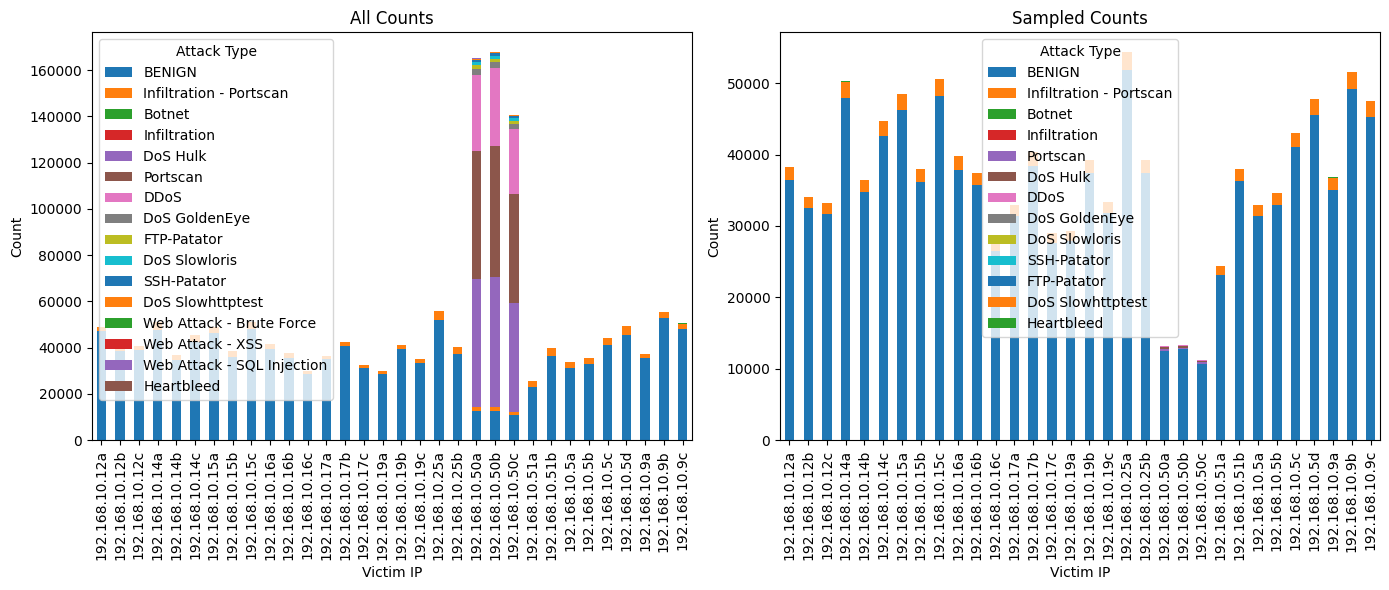

In [26]:
new_victim_IP = new_victim_df["Dvc Label"].value_counts().keys()
new_victim_IP = new_victim_IP.sort_values()
all_counts = pd.DataFrame()
sampled_all_counts = pd.DataFrame()
for curr_ip in new_victim_IP:
    curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == curr_ip]
    counts = curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    all_counts = pd.concat([all_counts, counts], axis=1)
    
    sampled_curr_ip_df = sample_df(curr_ip_df, anomaly_rate=0.05)
    counts = sampled_curr_ip_df["Label"].value_counts()
    counts.name = curr_ip
    sampled_all_counts = pd.concat([sampled_all_counts, counts], axis=1)
        
all_counts = all_counts.T
all_counts.sort_index(inplace=True)
sampled_all_counts = sampled_all_counts.T
sampled_all_counts.sort_index(inplace=True)


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Correct subplot usage

# Plot on the first subplot
all_counts.plot(kind='bar', stacked=True, ax=ax[0], title='All Counts')
ax[0].set_xlabel("Victim IP")
ax[0].set_ylabel("Count")
ax[0].legend(title="Attack Type")

# Plot on the second subplot
sampled_all_counts.plot(kind='bar', stacked=True, ax=ax[1], title='Sampled Counts')
ax[1].set_xlabel("Victim IP")
ax[1].set_ylabel("Count")
ax[1].legend(title="Attack Type")

plt.tight_layout()
plt.show()


<Figure size 100x200 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Frequency of Each Label in Dataset')

(array([0]), [Text(0, 0, 'count')])

<Figure size 100x200 with 0 Axes>

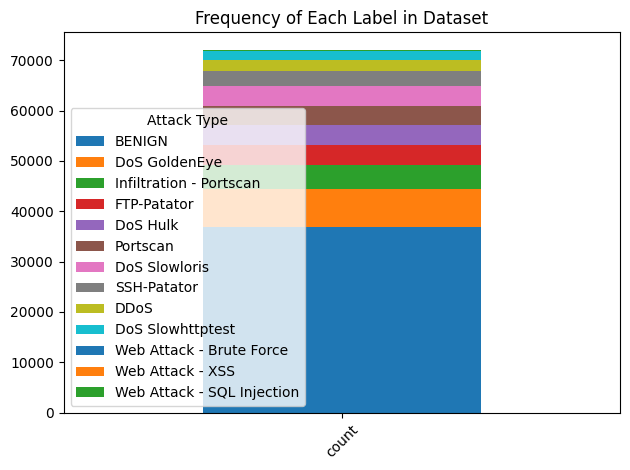

In [27]:
new_atk_df = victim_df[victim_df["Dvc Label"] == "192.168.10.50"]
benign_df = new_atk_df[new_atk_df["Label"] == "BENIGN"].sample(frac=1.0, random_state=42)
misc_atk_df = new_atk_df.loc[(new_atk_df["Label"] != "DDoS") &
                             (new_atk_df["Label"] != "DoS Hulk") &
                             (new_atk_df["Label"] != "Portscan") &
                             (new_atk_df["Label"] != "BENIGN") ].sample(frac=1.0, random_state=42)

common_atk_df = new_atk_df.loc[(new_atk_df["Label"] == "DDoS") |
                             (new_atk_df["Label"] == "DoS Hulk") |
                             (new_atk_df["Label"] == "Portscan") |
                             (new_atk_df["Label"] == "BENIGN") ].sample(frac=1.0, random_state=42)

new_atk_df = pd.concat([benign_df, misc_atk_df, common_atk_df[:benign_df.shape[0] - misc_atk_df.shape[0]]])

label_counts = new_atk_df["Label"].value_counts()
label_counts_df = pd.DataFrame(label_counts).T
# Plotting
plt.figure(figsize=(1, 2))
label_counts_df.plot(kind='bar', stacked=True)
plt.title('Frequency of Each Label in Dataset')
plt.xticks(rotation=45)
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

In [42]:
new_atk_df

,id,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,...,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label,Dvc Label
898306,204605,192.168.10.50-192.168.10.19-137-137-17,192.168.10.50,137,192.168.10.19,137,17,2017-07-05 15:09:39.761967,5,2,...,0,0.0,0.0,0,0,0,0,0,BENIGN,192.168.10.50
671882,300259,192.168.10.50-192.168.10.3-2476-53-17,192.168.10.50,2476,192.168.10.3,53,17,2017-07-04 17:24:41.256242,175,2,...,0,0.0,0.0,0,0,0,0,0,BENIGN,192.168.10.50
2008061,455643,192.168.10.50-192.168.10.3-43686-53-17,192.168.10.50,43686,192.168.10.3,53,17,2017-07-07 17:55:22.421821,157,2,...,0,0.0,0.0,0,0,0,0,0,BENIGN,192.168.10.50
1151641,457940,192.168.10.50-192.168.10.3-9381-53-17,192.168.10.50,9381,192.168.10.3,53,17,2017-07-05 13:40:28.649810,184,2,...,0,0.0,0.0,0,0,0,0,0,BENIGN,192.168.10.50
722250,28549,172.16.0.1-192.168.10.50-60224-80-6,172.16.0.1,60224,192.168.10.50,80,6,2017-07-05 13:05:44.212960,3003753,3,...,0,0.0,0.0,0,0,0,0,3003753,BENIGN,192.168.10.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097311,544893,172.16.0.1-192.168.10.50-54812-49160-6,172.16.0.1,54812,192.168.10.50,49160,6,2017-07-07 17:52:44.456185,44,1,...,0,0.0,0.0,0,0,0,0,44,Portscan,192.168.10.50
1936576,384158,172.16.0.1-192.168.10.50-37610-7999-6,172.16.0.1,37610,192.168.10.50,7999,6,2017-07-07 17:55:49.828908,73,1,...,0,0.0,0.0,0,0,0,0,73,Portscan,192.168.10.50
1945788,393370,172.16.0.1-192.168.10.50-60262-80-6,172.16.0.1,60262,192.168.10.50,80,6,2017-07-07 19:13:18.663029,1474096,9,...,0,0.0,0.0,0,0,0,0,1474096,DDoS,192.168.10.50
1846412,293994,172.16.0.1-192.168.10.50-54599-3546-6,172.16.0.1,54599,192.168.10.50,3546,6,2017-07-07 18:23:24.568029,50,1,...,0,0.0,0.0,0,0,0,0,50,Portscan,192.168.10.50


### Device Clustering

In [43]:
clustering_features = ['FWD Init Win Bytes', 'Bwd Packets/s', #Average everything
       'Bwd Init Win Bytes', 'Flow Duration', 'Packet Length Std',
       'PSH Flag Count', 'Fwd Packets/s', 
       'Average Packet Size',
       'Total Length of Bwd Packet', 'Bwd Packet Length Min',
       'Fwd IAT Min', 'Fwd Header Length', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Bwd Packet Length Mean',
       'Bwd Header Length', 'Packet Length Mean', 'Flow IAT Min', 'Label']
# Average all of this features
scaler = StandardScaler()
_ = scaler.fit_transform(new_victim_df[clustering_features].drop(columns=["Label"], axis=1, inplace=False))

avg_features_df = pd.DataFrame()
sampled_avg_features_df = pd.DataFrame()
for curr_ip in new_victim_IP:
  curr_ip_df = new_victim_df.loc[new_victim_df["Dvc Label"] == curr_ip]
  curr_ip_features = curr_ip_df[clustering_features].drop(columns=['Label'], axis = 1, inplace = False)
  scaled_features = scaler.transform(curr_ip_features)
  avg_features = pd.Series(scaled_features.mean(axis=0), index = clustering_features[:-1])
  avg_features.name = curr_ip
  avg_features_df = pd.concat([avg_features_df, avg_features],axis=1)
    
  #Sampled
  sampled_scaled_features = sample_df(curr_ip_df[clustering_features], 0.2)
  scaled_features = scaler.transform(sampled_scaled_features.drop(columns=["Label"], axis=1, inplace=False))
  sampled_avg_features = pd.Series(scaled_features.mean(axis=0), index = clustering_features[:-1])
  sampled_avg_features.name = curr_ip
  sampled_avg_features_df = pd.concat([sampled_avg_features_df, sampled_avg_features],axis=1)  
  
# Add New Atk Df
curr_ip_features = new_atk_df[clustering_features].drop(columns=["Label"], axis=1, inplace=False)
scaled_features = scaler.transform(curr_ip_features)
sampled_avg_features = pd.Series(scaled_features.mean(axis=0), index = clustering_features[:-1])
sampled_avg_features.name = "new_atk"
sampled_avg_features_df = pd.concat([sampled_avg_features_df, sampled_avg_features],axis=1)  
  
avg_features_df = avg_features_df.T
avg_features_df.sort_index(inplace=True)
sampled_avg_features_df = sampled_avg_features_df.T
sampled_avg_features_df.sort_index(inplace=True)
#average all the column values



The palette list has fewer values (31) than needed (32) and will cycle, which may produce an uninterpretable plot.


<Axes: xlabel='dimension 1', ylabel='dimension 2'>

Text(0.5, 1.0, 'Device Feature Projection (Before Sampling)')


The palette list has fewer values (31) than needed (33) and will cycle, which may produce an uninterpretable plot.


<Axes: xlabel='dimension 1', ylabel='dimension 2'>

Text(0.5, 1.0, 'Device Feature Projection (After Sampling)')

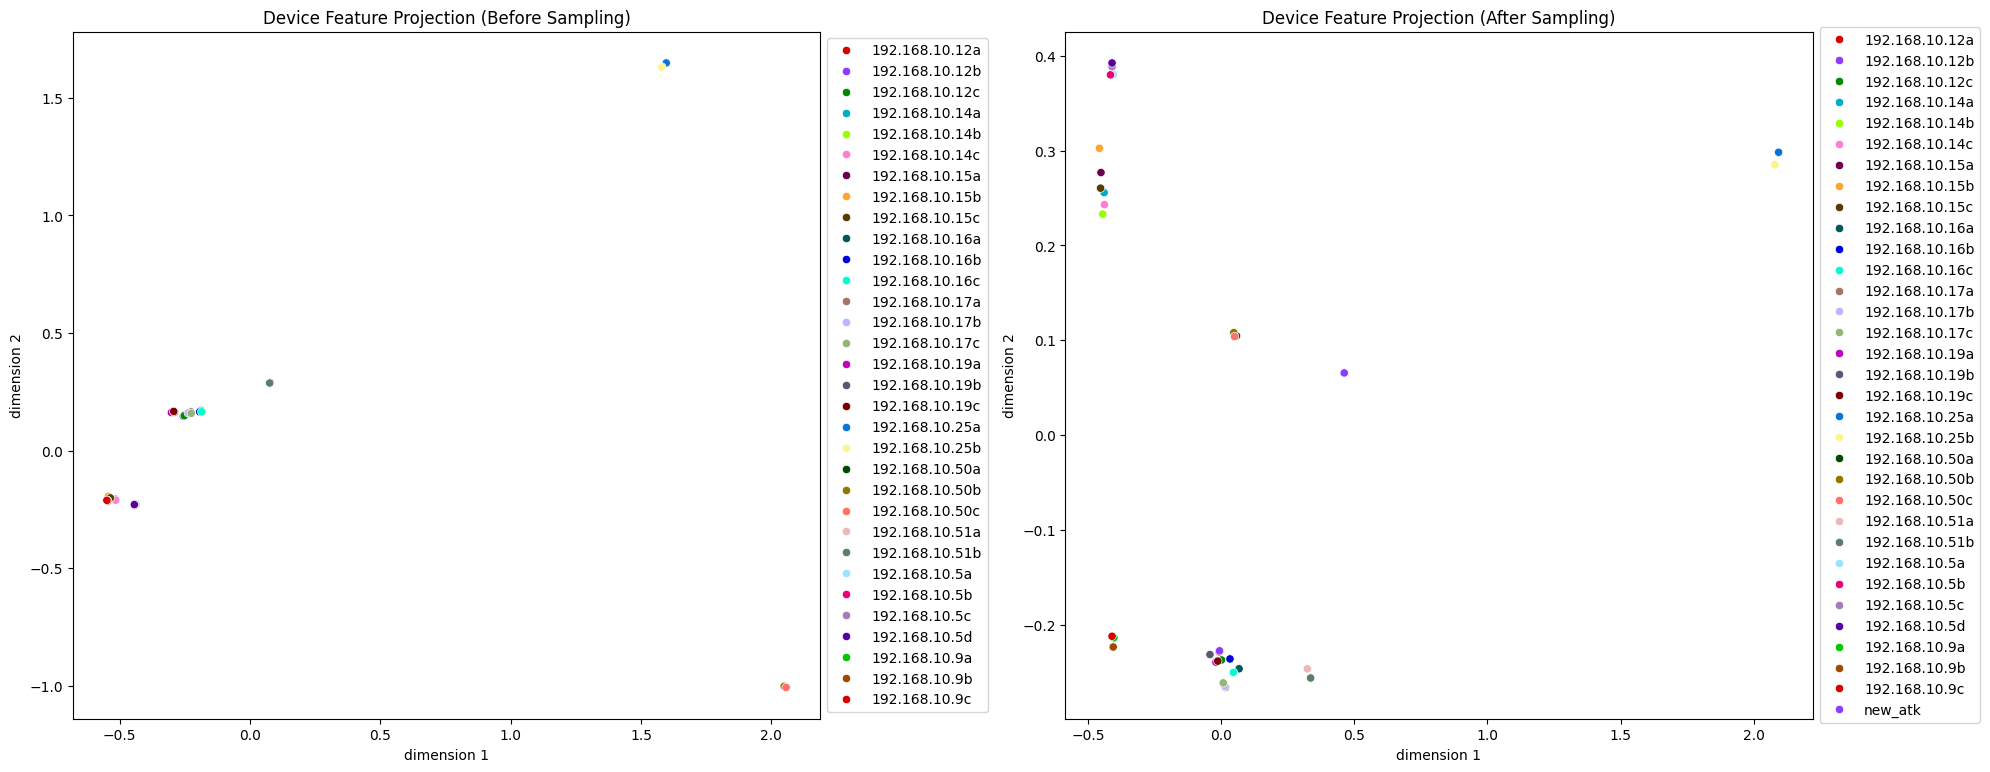

In [44]:
# PCA Transformation and Plotting for Original Data
import colorcet as cc

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(avg_features_df[:])
y = avg_features_df.index
pca_df = pd.DataFrame({
    "Dvc Label": y,
    "dimension 1": z[:, 0],
    "dimension 2": z[:, 1]
})

# PCA Transformation and Plotting for Sampled Data
pca_sampled = PCA(n_components=2, random_state=42)
z_sampled = pca_sampled.fit_transform(sampled_avg_features_df[:])
y_sampled = sampled_avg_features_df.index
sampled_pca_df = pd.DataFrame({
    "Dvc Label": y_sampled,
    "dimension 1": z_sampled[:, 0],
    "dimension 2": z_sampled[:, 1]
})

# Plot both PCA results side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Set up a figure with two subplots
palette = sns.color_palette(cc.glasbey, n_colors=31)
# Plot for Original Data
sns.scatterplot(ax=axes[0],
                x='dimension 1', y='dimension 2',
                hue='Dvc Label',
                palette=palette,
                data=pca_df)
axes[0].set_title('Device Feature Projection (Before Sampling)')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot for Sampled Data
sns.scatterplot(ax=axes[1],
                x='dimension 1', y='dimension 2',
                hue='Dvc Label',
                palette=palette,
                data=sampled_pca_df)
axes[1].set_title('Device Feature Projection (After Sampling)')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Adjust layout to make room for legends outside the plots
plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


KMeans(n_clusters=4, random_state=42)

[Text(0.5, 1.0, 'Device 1 Label Projection')]

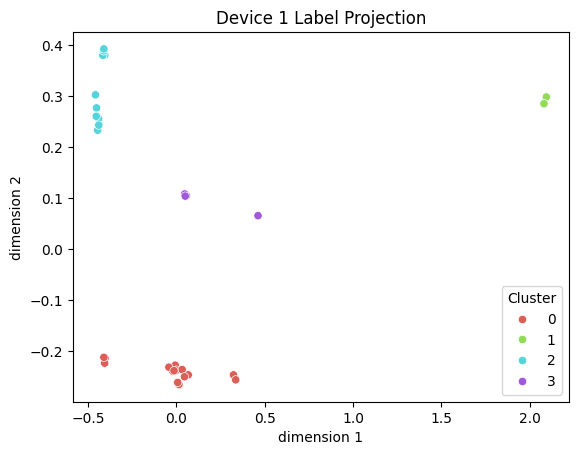

In [45]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_scaled is already defined and preprocessed
# Reduce dimensionality using PCA


# Initialize and fit K-means model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(sampled_avg_features_df)

# Predict clusters
preds = kmeans.predict(sampled_avg_features_df)



# Plotting the first two principal components
sns.scatterplot(x='dimension 1', y='dimension 2',
                hue=preds, 
                palette=sns.color_palette('hls', 4),  # Adjusted to match the number of clusters
                data=sampled_pca_df).set(title='Device 1 Label Projection')

# Show the plot
plt.legend(title='Cluster')
plt.show()


In [46]:
dvc = sampled_avg_features_df.index
for cluster in np.unique(preds):
  idx = np.where(preds == cluster)
  print(f"Cluster {cluster}: {dvc[idx]}")

Cluster 0: Index(['192.168.10.12a', '192.168.10.12b', '192.168.10.12c', '192.168.10.16a',
       '192.168.10.16b', '192.168.10.16c', '192.168.10.17a', '192.168.10.17b',
       '192.168.10.17c', '192.168.10.19a', '192.168.10.19b', '192.168.10.19c',
       '192.168.10.51a', '192.168.10.51b', '192.168.10.9a', '192.168.10.9b',
       '192.168.10.9c'],
      dtype='object')
Cluster 1: Index(['192.168.10.25a', '192.168.10.25b'], dtype='object')
Cluster 2: Index(['192.168.10.14a', '192.168.10.14b', '192.168.10.14c', '192.168.10.15a',
       '192.168.10.15b', '192.168.10.15c', '192.168.10.5a', '192.168.10.5b',
       '192.168.10.5c', '192.168.10.5d'],
      dtype='object')
Cluster 3: Index(['192.168.10.50a', '192.168.10.50b', '192.168.10.50c', 'new_atk'], dtype='object')


'192.168.10.12a'

### Performance Evaluation GM LM

Scenario 1

In [21]:
# Read the csv and clean it

def eval_model_unsupervised(new_victim_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        # 'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP},
        'lm_acc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    Xgm_train, Xgm_test, y_train, y_test, scaler = process_dataset(new_victim_df, anomaly_rate)
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp', 'Dvc Label']
    Xgm_train.drop(dropping_cols, axis = 1, inplace = True)     
    
    Xgm_train_scaled = scaler.fit_transform(Xgm_train)
    Xgm_train_scaled = pd.DataFrame(Xgm_train_scaled, columns=Xgm_train.columns)    

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)
        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
        # Train the model
        path = f"gm_1_{supervision_rate}.pkl"
        if os.path.exists(path):
            with open(path, 'rb') as f:
                clf = pickle.load(f)
        else:
            clf = model(device='cuda', verbose=1, epochs=1)
            clf.fit(X=Xgm_train_scaled.to_numpy(), y=y)  
            
            # with open(path, 'wb') as f:
            #     pickle.dump(clf, f)
        
        roc_auc, Xgm_test_scaled, gm_pred = perform_inference(Xgm_test, y_test, dropping_cols, scaler, clf, curr_ip=None)
        
        train_perc = 0.6
        Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgm_test, 
                                                            gm_pred, 
                                                            test_size=1 - train_perc, 
                                                            shuffle=True, 
                                                            stratify=gm_pred, 
                                                            random_state=42)      
        ylm_test = pd.DataFrame(ylm_test, columns=["Label"], index = Xlm_test.index)
        # Initialize the CART classifier
        cart_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=4022)
        # Train the classifier on the training data
        Xlm_train.drop(dropping_cols, axis = 1, inplace = True)     
        Xlm_train_scaled = scaler.transform(Xlm_train)             
        cart_classifier.fit(Xlm_train_scaled, ylm_train)            
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate
            curr_Xlm_test = Xlm_test.loc[Xlm_test["Dvc Label"] == curr_ip].copy()
            curr_ylm_test = ylm_test.loc[Xlm_test["Dvc Label"] == curr_ip].copy()
            # Store metrics for GM
            # metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 
            # Use the obtained labels to train LM
            dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                        'Dst Port', 'Timestamp', 'Dvc Label']    
            curr_Xlm_test.drop(dropping_cols, axis = 1, inplace = True)     
            curr_Xlm_test_scaled = scaler.transform(curr_Xlm_test)            
            

            cart_predictions = cart_classifier.predict(curr_Xlm_test_scaled)
            # Evaluate accuracy
            acc = accuracy_score(curr_ylm_test, cart_predictions)            
            metrics_dict['lm_acc'][curr_ip][supervision_rate] += acc

    return metrics_dict



In [24]:
victim_IP = new_victim_IP
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]


model = PReNet
model.random_state = 42
metrics_dict = eval_model_unsupervised(new_victim_df, supervision_rate_list, model, new_victim_IP)

SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1


KeyboardInterrupt: 

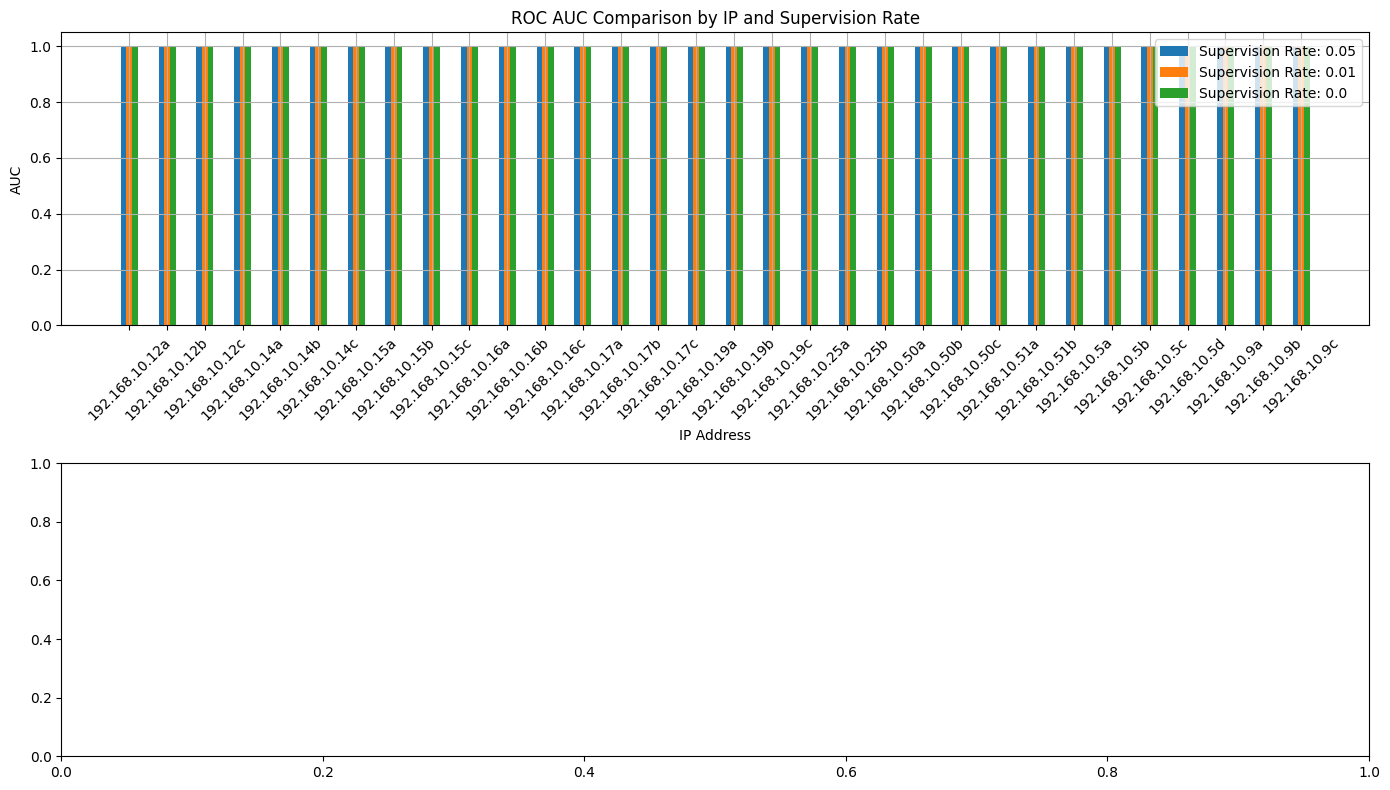

{'lm_acc': {'192.168.10.12a': {0.05: 0.9998771272347484, 0.01: 0.9998143104728894, 0.0: 0.9997538461538461}, '192.168.10.12b': {0.05: 1.0, 0.01: 0.9998492159227985, 0.0: 0.9996943531749064}, '192.168.10.12c': {0.05: 1.0, 0.01: 0.9996293825513305, 0.0: 1.0}, '192.168.10.14a': {0.05: 0.9998182148700236, 0.01: 0.999938755512004, 0.0: 0.9996948614671061}, '192.168.10.14b': {0.05: 0.9998324677500419, 0.01: 0.9998329714381159, 0.0: 0.9995834027662056}, '192.168.10.14c': {0.05: 0.9998629292029333, 0.01: 1.0, 0.0: 0.999724099875845}, '192.168.10.15a': {0.05: 0.9998730561726437, 0.01: 0.9997487121497676, 0.0: 0.9995600804424334}, '192.168.10.15b': {0.05: 0.999758025487982, 0.01: 0.9998371600716496, 0.0: 0.9991915925626516}, '192.168.10.15c': {0.05: 1.0, 0.01: 0.9998794527153276, 0.0: 0.9995725973867383}, '192.168.10.16a': {0.05: 0.9999257774808877, 0.01: 0.9996336459554513, 0.0: 0.9998519395913533}, '192.168.10.16b': {0.05: 0.9999180999180999, 0.01: 0.9997526793075021, 0.0: 0.9999172733289212},

In [131]:
plot_graph_scenario(metrics_dict, supervision_rate_list)
print(metrics_dict)

Scenario 2

In [86]:
# Read the csv and clean it
def eval_model_unsupervised(new_victim_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP},
        'lm_acc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    Xgm_train, Xgmm_test, y_train, y_test, scaler = process_dataset(new_victim_df, anomaly_rate)
    dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp', 'Dvc Label']
    Xgm_train.drop(dropping_cols, axis = 1, inplace = True)     
    
    Xgm_train_scaled = scaler.fit_transform(Xgm_train)
    Xgm_train_scaled = pd.DataFrame(Xgm_train_scaled, columns=Xgm_train.columns)    

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)

        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
            
 
        
        # Train the model
        path = f"gm_1_{supervision_rate}.pkl"
        if os.path.exists(path):
            with open(path, 'rb') as f:
                clf = pickle.load(f)
        else:
            clf = model(device='cuda', verbose=1, epochs=1)
            clf.fit(X=Xgm_train_scaled.to_numpy(), y=y)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
        # Load Model Instead      
        
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate

            roc_auc, curr_X_test_scaled, gm_pred = perform_inference(Xgmm_test, y_test, curr_ip, dropping_cols, scaler, clf)
            # Store metrics for GM
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 
            # Use the obtained labels to train LM
            acc = lm_eval_2(curr_X_test_scaled, gm_pred)
            metrics_dict['lm_acc'][curr_ip][supervision_rate] += acc
            
                      
            

    return metrics_dict



In [87]:
victim_IP = new_victim_IP
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]


model = PReNet
model.random_state = 42
metrics_dict = eval_model_unsupervised(new_victim_df, supervision_rate_list, model, new_victim_IP)

SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.371331, time: 157.0s
Start Inference on the training data...
Accuracy: 0.9999381494309748
Accuracy: 0.9999241447318516
Accuracy: 0.9999255620068483
Accuracy: 0.9998780115888991
Accuracy: 0.9998315931289997
Accuracy: 1.0
Accuracy: 0.9998738568274992
Accuracy: 0.9998388266580708
Accuracy: 0.9999393498301795
Accuracy: 0.999925744412267
Accuracy: 0.9996718621821165
Accuracy: 0.9998975619750051
Accuracy: 0.9999161355249916
Accuracy: 0.9999283051333524
Accuracy: 0.999811106913487
Accuracy: 0.9997951239500102
Accuracy: 0.9996274772761139
Accuracy: 0.9997362869198312
Accuracy: 0.9999437507031163
Accuracy: 1.0
Accuracy: 0.9949119373776908
Accuracy: 0.9952162265595101
Accuracy: 0.9966996699669967
Accuracy: 0.9996240130342148
Accuracy: 1.0
Accuracy: 0.9999074331204295
Accuracy: 0.9999113239336703
Accuracy: 0.9998577929465301
Accuracy: 0.9999359672152142
Accuracy: 0.9999176276771

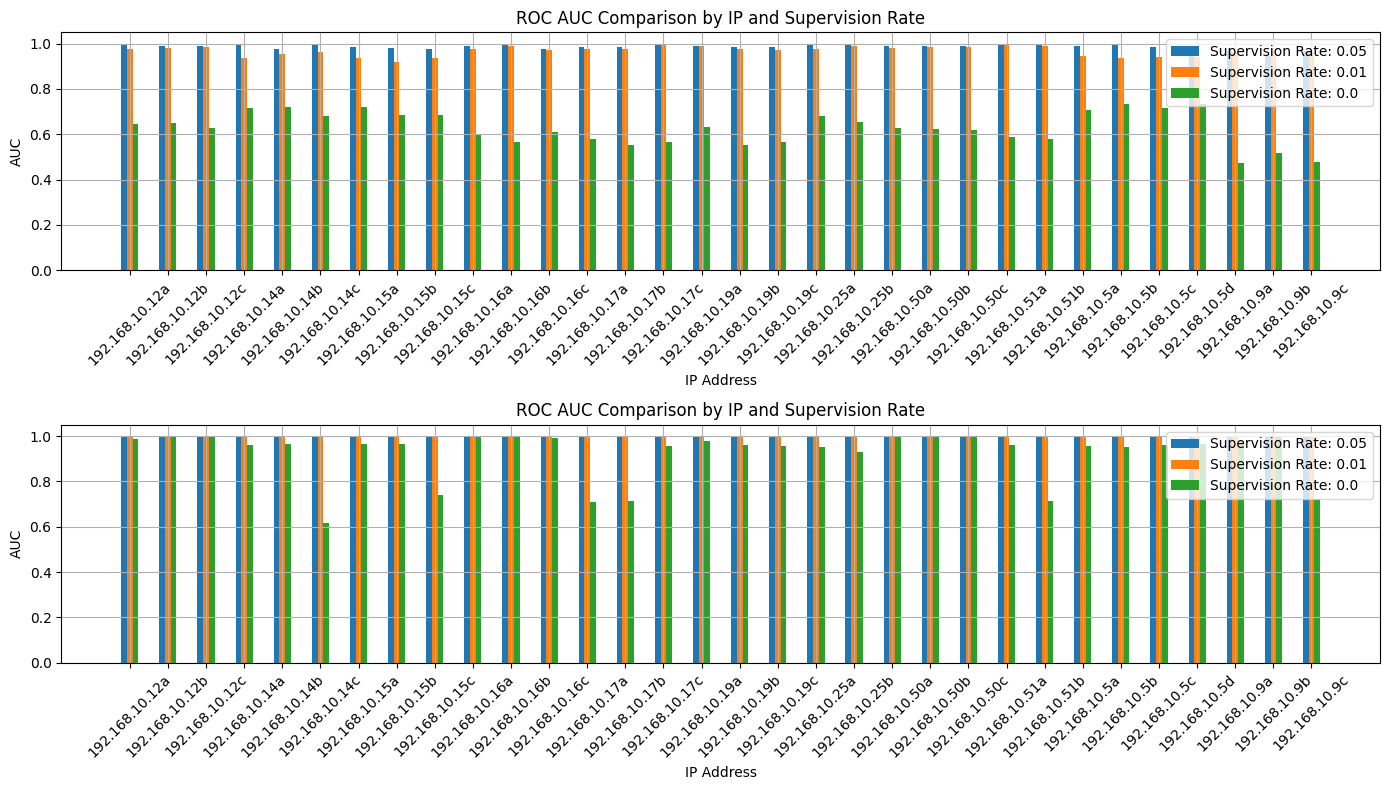

{'roc_auc': {'192.168.10.12a': {0.05: 0.9921270787852972, 0.01: 0.9772195303764444, 0.0: 0.6435560051825426}, '192.168.10.12b': {0.05: 0.9883231335878979, 0.01: 0.9807520053779559, 0.0: 0.649128757023996}, '192.168.10.12c': {0.05: 0.9901270029129922, 0.01: 0.9851629849784758, 0.0: 0.6268765823649832}, '192.168.10.14a': {0.05: 0.9915289733274606, 0.01: 0.9359406110960891, 0.0: 0.7140928560116475}, '192.168.10.14b': {0.05: 0.9775523752147235, 0.01: 0.9541289049350664, 0.0: 0.7197620089891341}, '192.168.10.14c': {0.05: 0.9942970513514705, 0.01: 0.9631439711016938, 0.0: 0.6804428311747306}, '192.168.10.15a': {0.05: 0.9856975626794751, 0.01: 0.9383385029681806, 0.0: 0.7178898875825747}, '192.168.10.15b': {0.05: 0.9791383800945801, 0.01: 0.9197714983988523, 0.0: 0.6865972111089489}, '192.168.10.15c': {0.05: 0.976421441852814, 0.01: 0.9382118108767237, 0.0: 0.6841858014229587}, '192.168.10.16a': {0.05: 0.9913125934121014, 0.01: 0.977872125893867, 0.0: 0.601553156760926}, '192.168.10.16b': {0.

In [88]:
plot_graph_scenario(metrics_dict, supervision_rate_list)
print(metrics_dict)

## Performace New Attack

### Scenario 2

In [26]:
victim_IP = new_victim_IP
anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
# supervision_rate_list = [1.0, 0.25, 0.05, 0.0]
supervision_rate_list = [0.05, 0.01, 0.0]

model = PReNet
model.random_state = 42
supervision_rate = 0.05
anomaly_rate = 0.05
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']


In [27]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):


    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


In [29]:
supervision_rate = 0.01
model = PReNet
model.random_state = 42

Xgm_train, Xgmm_test, y_train, y_test, scaler = process_dataset(new_victim_df, anomaly_rate)
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp', 'Dvc Label']
Xgm_train.drop(dropping_cols, axis = 1, inplace = True)     

Xgm_train_scaled = scaler.fit_transform(Xgm_train)
Xgm_train_scaled = pd.DataFrame(Xgm_train_scaled, columns=Xgm_train.columns)    

gm_clf = train_gm(Xgm_train_scaled, y_train, supervision_rate, model)

SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.160380, time: 154.5s
Start Inference on the training data...


In [30]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)

### Active Learning for data upload selection

In [29]:
Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, y_test, scaler, gm_clf, lm_clf)

# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

gm_opt_threshold is 3.005056142807007
Accuracy: 0.9969070330124922


Uploading All

In [ ]:


accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.0
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

Accuracy before update: 0.546137040714995
Total Uploaded Data 50350
Percentage of misclassied data that is uploaded: 1.0
Total Data Uploaded: 1.0
Accuracy of GM before update: 0.9764448857994041
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.160380, time: 154.1s
Start Inference on the training data...
Accuracy of GM after update: 0.9764647467725919
Accuracy of updated LM: 0.9758109360519


Uploading Select (CART)

In [30]:
Y_new = new_atk_df["Label"].map({"BENIGN":0}).fillna(1)
X_new = new_atk_df.drop(columns = dropping_cols+["Label"], axis=1, inplace=False)
X_new_scaled = scaler.transform(X_new)
train_perc = 0.7
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new_scaled, 
                                                    Y_new, 
                                                    test_size=1 - train_perc, 
                                                    shuffle=True, 
                                                    stratify=Y_new, 
                                                    random_state=42)  
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, cart_probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
  
forward_gm_idx = get_low_confidence_data(cart_probabilities, mismatch_indices)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xlm_train, Ylm_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

Uploading Select XGBoost

In [34]:
from sklearn.calibration import CalibratedClassifierCV

Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     

Xlm_scaled = scaler.fit_transform(Xlm)
Xlm_scaled = pd.DataFrame(Xlm_scaled, columns=Xlm.columns)  
lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, 
                       learning_rate=0.1)
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, ylm, scaler, gm_clf, lm_clf)

# calibrated_probabilities = calibrated_clf.predict_proba(X_test)
# gm_opt_threshold is 2.594822645187378
# Accuracy: 0.9839122424732192

gm_opt_threshold is 3.005056142807007
Accuracy: 0.9991822637824629


In [32]:
ynew_train = ynew_train.reset_index(drop=True)
ynew_test = ynew_test.reset_index(drop=True)
accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.1
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)
new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

Accuracy before update: 0.546137040714995
Total Uploaded Data 2253
Percentage of misclassied data that is uploaded: 0.018335375459478383
Total Data Uploaded: 0.044746772591857
Accuracy of GM before update: 0.9977807367953839
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.160380, time: 153.6s
Start Inference on the training data...
Accuracy of GM after update: 0.9977807367953839
Accuracy of updated LM: 0.8843373493975903


modAL for Active Learning

In [54]:

Xlm = Xgmm_test.copy()
ylm = y_test.copy()
Xlm.drop(dropping_cols, axis = 1, inplace = True)     



lm_clf = "Comittee"
lm_clf, gm_opt_threshold, Xlm_train, Ylm_train = train_lm(new_victim_IP, Xlm_scaled, ylm, scaler, gm_clf, lm_clf)



gm_opt_threshold is 3.0701518058776855
Accuracy: 0.9982394620257731


In [55]:
from modAL.uncertainty import classifier_uncertainty

accuracy, probabilities, mismatch_indices = new_attacks_inference(lm_clf, Xnew_train, ynew_train , scaler)
threshold = 0.4
forward_gm_idx = get_low_confidence_data(probabilities, mismatch_indices, threshold)

new_lm_clf = upload_gm(Xnew_train[forward_gm_idx[0]], ynew_train[forward_gm_idx[0]],
          gm_clf, lm_clf, gm_opt_threshold, Xgm_train_scaled, y_train)

eval_updated_lm(Xnew_test, ynew_test, new_lm_clf)

Accuracy before update: 0.4984508440913605
Total Uploaded Data 9880
Percentage of misclassied data that is uploaded: 0.32427830356789294
Total Data Uploaded: 0.19622641509433963
Accuracy of GM before update: 0.9811740890688259
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.01
Start Training...
ensemble size: 1
epoch  1, training loss: 0.160380, time: 160.9s
Start Inference on the training data...
Accuracy of GM after update: 0.9809716599190283
Accuracy of updated LM: 0.9868396663577387


In [43]:

alibox = ToolBox(X=X_new, y=Y_new, query_type='AllLabels')

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=1)

alibox.get_split(round= None)


([array([36241,  7909, 21292, ...,   556, 44254, 40322])],
 [array([27572,  3905, 31572, ...,  4019, 30876, 29668])],
 [array([36241,  7909, 21292, ..., 27782, 36662, 51482])],
 [array([20692,  5124, 48721, ...,   556, 44254, 40322])])

([array([36241,  7909, 21292, ...,   556, 44254, 40322])],
 [array([27572,  3905, 31572, ...,  4019, 30876, 29668])],
 [array([36241,  7909, 21292, ..., 27782, 36662, 51482])],
 [array([20692,  5124, 48721, ...,   556, 44254, 40322])])

In [44]:




alibox = ToolBox(X=X_new, y=Y_new, query_type='AllLabels')

# Split data
alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=2)

# Use the default Logistic Regression classifier
model =  DecisionTreeClassifier(criterion='entropy', max_depth=5,  
                                min_samples_leaf=10, 
                                # ccp_alpha=0.01, #Pruning coef
                                random_state=4022)

# The cost budget is 50 times querying
stopping_criterion = alibox.get_stopping_criterion('num_of_queries', 50)


def main_loop(alibox, strategy, round):
    # Get the data split of one fold experiment
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
    # Get intermediate results saver for one fold experiment
    saver = alibox.get_stateio(round)

    # Set initial performance point
    model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
    pred = model.predict(X[test_idx, :])
    accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                              y_pred=pred,
                                              performance_metric='accuracy_score')
    saver.set_initial_point(accuracy)

    # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
    while not stopping_criterion.is_stop():
        # Select a subset of Uind according to the query strategy
        # Passing model=None to use the default model for evaluating the committees' disagreement
        select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, batch_size=10)
        label_ind.update(select_ind)
        unlab_ind.difference_update(select_ind)

        # Update model and calc performance according to the model you are using
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')

        # Save intermediate results to file
        st = alibox.State(select_index=select_ind, performance=accuracy)
        saver.add_state(st)

        # Passing the current progress to stopping criterion object
        stopping_criterion.update_information(saver)
    # Reset the progress in stopping criterion object
    stopping_criterion.reset()
    return saver


unc_result = []
qbc_result = []
eer_result = []
quire_result = []
density_result = []
bmdr_result = []
spal_result = []
lal_result = []
rnd_result = []

_I_have_installed_the_cvxpy = False

for round in range(2):
    train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

    # Use pre-defined strategy
    unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")
    qbc = alibox.get_query_strategy(strategy_name="QueryInstanceQBC")
    eer = alibox.get_query_strategy(strategy_name="QueryExpectedErrorReduction")
    rnd = alibox.get_query_strategy(strategy_name="QueryInstanceRandom")
    quire = alibox.get_query_strategy(strategy_name="QueryInstanceQUIRE", train_idx=train_idx)
    density = alibox.get_query_strategy(strategy_name="QueryInstanceGraphDensity", train_idx=train_idx)
    lal = alibox.get_query_strategy(strategy_name="QueryInstanceLAL", cls_est=10, train_slt=False)
    lal.download_data()
    lal.train_selector_from_file(reg_est=30, reg_depth=5)

    unc_result.append(copy.deepcopy(main_loop(alibox, unc, round)))
    qbc_result.append(copy.deepcopy(main_loop(alibox, qbc, round)))
    eer_result.append(copy.deepcopy(main_loop(alibox, eer, round)))
    rnd_result.append(copy.deepcopy(main_loop(alibox, rnd, round)))
    quire_result.append(copy.deepcopy(main_loop(alibox, quire, round)))
    density_result.append(copy.deepcopy(main_loop(alibox, density, round)))
    lal_result.append(copy.deepcopy(main_loop(alibox, lal, round)))

    if _I_have_installed_the_cvxpy:
        bmdr = alibox.get_query_strategy(strategy_name="QueryInstanceBMDR", kernel='rbf')
        spal = alibox.get_query_strategy(strategy_name="QueryInstanceSPAL", kernel='rbf')

        bmdr_result.append(copy.deepcopy(main_loop(alibox, bmdr, round)))
        spal_result.append(copy.deepcopy(main_loop(alibox, spal, round)))

analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')
analyser.add_method(method_name='QBC', method_results=qbc_result)
analyser.add_method(method_name='Unc', method_results=unc_result)
analyser.add_method(method_name='EER', method_results=eer_result)
analyser.add_method(method_name='Random', method_results=rnd_result)
analyser.add_method(method_name='QUIRE', method_results=quire_result)
analyser.add_method(method_name='Density', method_results=density_result)
analyser.add_method(method_name='LAL', method_results=lal_result)
if _I_have_installed_the_cvxpy:
    analyser.add_method(method_name='BMDR', method_results=bmdr_result)
    analyser.add_method(method_name='SPAL', method_results=spal_result)
print(analyser)
analyser.plot_learning_curves(title='Example of alipy', std_area=False)

([array([40460, 40403, 11160, ...,  8604, 16223, 25405]),
  array([ 6151, 30583, 15272, ..., 52622, 63912, 56807])],
 [array([13573, 62566, 18732, ..., 65723,  7750,  6481]),
  array([29160, 12121, 22776, ..., 42845, 16003, 25402])],
 [array([40460, 40403, 11160, ..., 63887, 41581, 14076]),
  array([ 6151, 30583, 15272, ..., 58531, 42479, 64687])],
 [array([19513, 55144, 66356, ...,  8604, 16223, 25405]),
  array([50440, 64010, 11804, ..., 52622, 63912, 56807])])

### Using Seperate model to detect unknowns